In [ ]:
import gdown, zipfile, cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
from sklearn.metrics.pairwise import euclidean_distances

In [ ]:
def load_images(paths, size=(100, 100)):
    images = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, size)
        img = img / 127.5 - 1.0
        images.append(img)
    return np.array(images)

image_paths = glob("/kaggle/input/uasdl23/A_23/*.jpg")
images = load_images(image_paths, size=(100, 100))

print("Shape:", images.shape)

Shape: (1074, 100, 100, 3)


Pertama, saya melakukan load pada dataset gambar pistachio yang akan digunakan sebagai real image reference untuk melatih model GAN. Saya menggunakan cv2.imread untuk membaca gambar, kemudian mengubah warna dari BGR ke RGB agar sesuai dengan format standar visualisasi. Setiap gambar diresize menjadi 100x100 pixel, mengikuti ketentuan ukuran target output pada generator. Terakhir, pixel dinormalisasi ke rentang [-1, 1] menggunakan rumus img / 127.5 - 1.0 karena fungsi aktivasi akhir generator adalah tanh, yang membutuhkan input dalam rentang tersebut.

Kemudian saya menampilkan 10 contoh gambar pertama untuk memastikan proses loading dan preprocessing berjalan dengan baik. Secara visual, gambar pistachio terlihat konsisten, memiliki latar belakang hitam, dan variasi bentuk yang cukup baik.

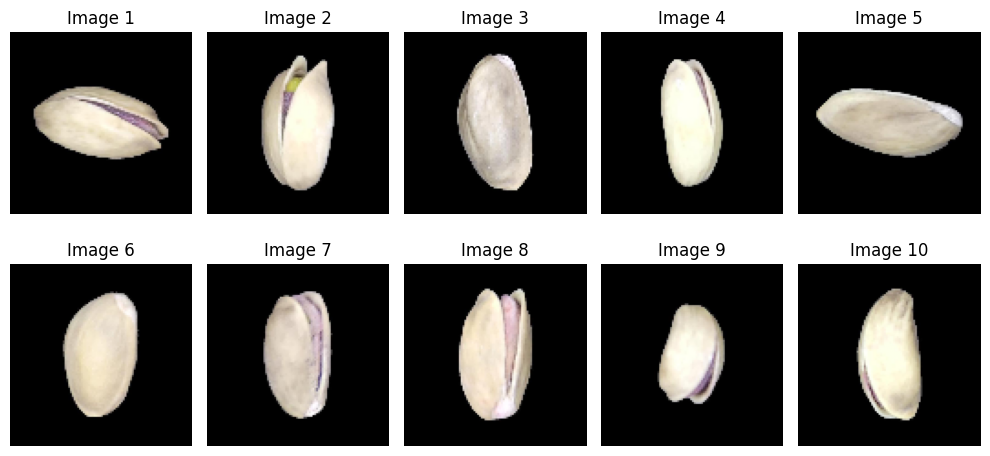

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    image_rescaled = (images[i] + 1) / 2.0
    plt.imshow(image_rescaled)
    plt.title(f"Image {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()

## A. Baseline GAN

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(106*106*64, activation='relu'),
        layers.Reshape((106, 106, 64)),

        layers.Conv2D(64, (3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(32, (3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(16, (3,3), strides=1, padding='valid', activation='relu'),

        layers.Conv2D(3, (1,1), strides=1, padding='valid', activation='tanh')
    ])
    return model


In [ ]:
generator = build_generator()

Untuk membangun model generator pada baseline GAN, saya mengikuti spesifikasi yang diminta pada soal. Generator menerima input berupa vektor noise berdimensi 100 yang diambil dari distribusi Gaussian (normal distribution). Vektor ini kemudian diproses oleh sebuah Dense layer yang mengubahnya menjadi tensor berdimensi 106×106×64, yaitu 7.191.104 unit yang kemudian di-reshape menjadi bentuk spasial tiga dimensi (106, 106, 64).

Setelah reshape, tensor ini diproses melalui tiga buah convolutional layer dengan kernel 3×3, stride 1, dan padding valid, seperti yang diminta pada soal. Layer pertama memiliki 64 filter, diikuti oleh layer kedua dengan 32 filter, dan layer ketiga dengan 16 filter. Semua layer ini menggunakan fungsi aktivasi ReLU sesuai ketentuan. Selanjutnya, terdapat satu layer konvolusi tambahan (Conv2D) dengan kernel 1×1 dan 3 filter (RGB), menggunakan fungsi aktivasi Tanh untuk mengubah output ke rentang [-1, 1], menghasilkan gambar berdimensi akhir 100×100×3.

Secara keseluruhan, arsitektur generator ini sudah sesuai dengan spesifikasi soal, yaitu:
* Tiga layer Conv2D dengan kernel 3×3, stride 1, padding valid, dan jumlah filter 64, 32, 16 secara berurutan
* Activation function ReLU untuk semua layer kecuali layer terakhir
* Layer akhir menggunakan aktivasi Tanh
* Target output adalah gambar ukuran 100×100×3
* Input adalah noise dari distribusi Gaussian.


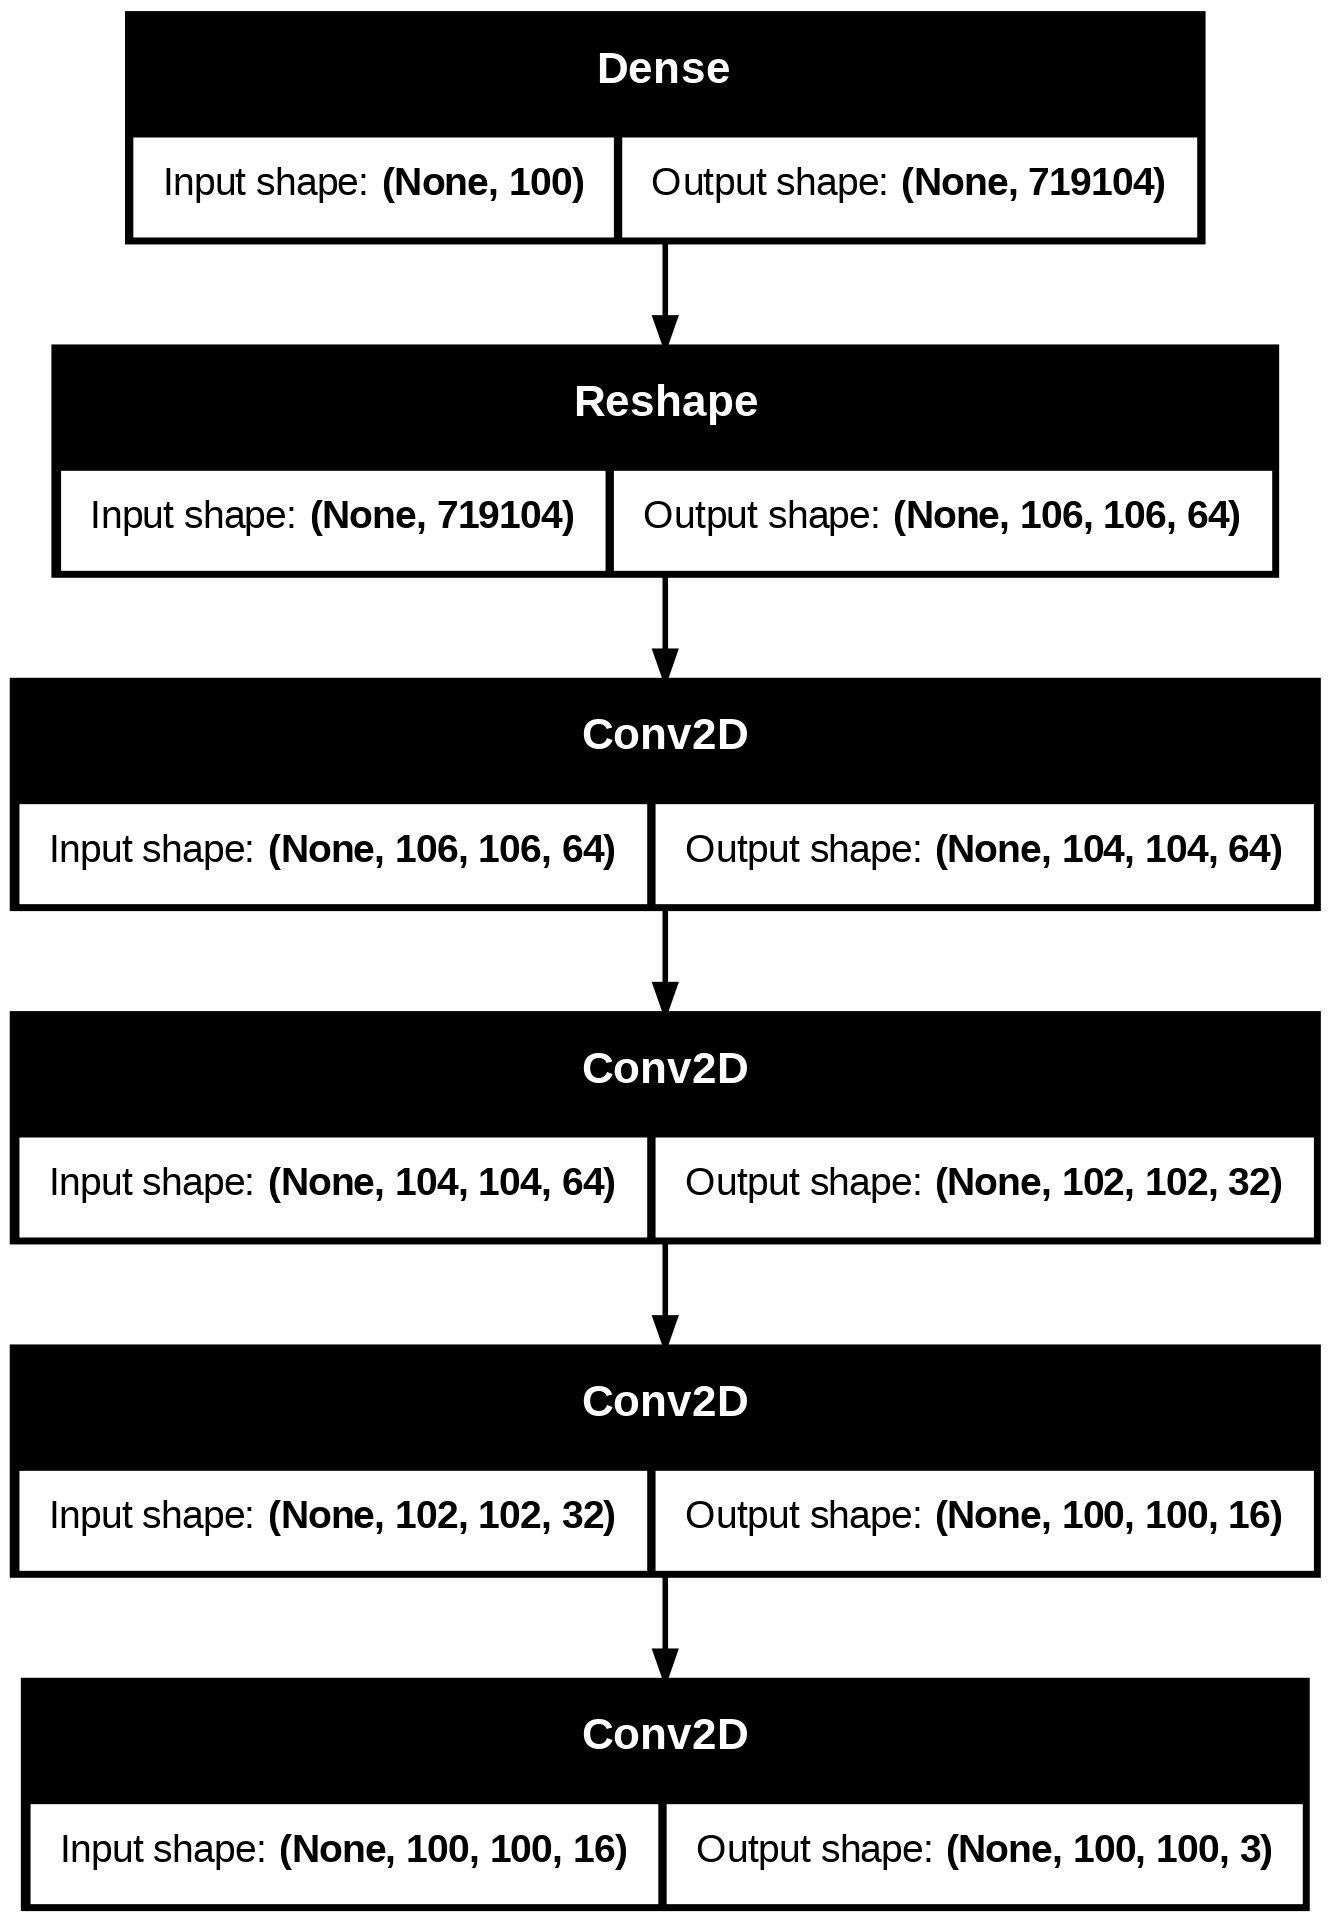

In [ ]:
tf.keras.utils.plot_model(generator, show_shapes=True)

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Input(shape=(100, 100, 3)),
        layers.Conv2D(16, (3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(32, (3,3), strides=1, padding='valid', activation='relu'),
        layers.Conv2D(64, (3,3), strides=1, padding='valid', activation='relu'),
        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


Model discriminator yang dibangun bertujuan untuk membedakan antara gambar asli dan gambar sintetis hasil generator. Input dari model ini adalah gambar berukuran 100×100×3. Gambar ini kemudian diproses melalui tiga buah layer Conv2D, masing-masing dengan kernel berukuran 3×3, stride 1, dan padding valid, sesuai dengan spesifikasi pada soal. Ketiga layer ini menggunakan fungsi aktivasi ReLU dan memiliki jumlah filter yang meningkat secara progresif, yaitu 16, 32, dan 64 filter.

Setelah melalui layer konvolusi, hasilnya di-flatten menjadi satu dimensi sebelum diproses oleh layer Dense akhir yang memiliki satu neuron. Neuron ini menggunakan fungsi aktivasi sigmoid untuk mengeluarkan probabilitas antara 0 dan 1, yang merepresentasikan seberapa besar kemungkinan input merupakan gambar nyata (daripada hasil buatan generator).

Secara keseluruhan, arsitektur discriminator sudah sesuai dengan ketentuan soal, yaitu:
* Tiga layer Conv2D dengan kernel 3×3, stride 1, padding valid, dan jumlah filter 16, 32, dan 64
* Aktivasi ReLU digunakan pada semua layer convolution
* Fully connected layer terakhir hanya satu buah, dengan fungsi aktivasi sigmoid

In [ ]:
discriminator = build_discriminator()
decision = discriminator(images)
print (decision)

I0000 00:00:1750939654.532525      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


tf.Tensor(
[[0.537229  ]
 [0.54369926]
 [0.5649447 ]
 ...
 [0.5587248 ]
 [0.5463239 ]
 [0.54105365]], shape=(1074, 1), dtype=float32)


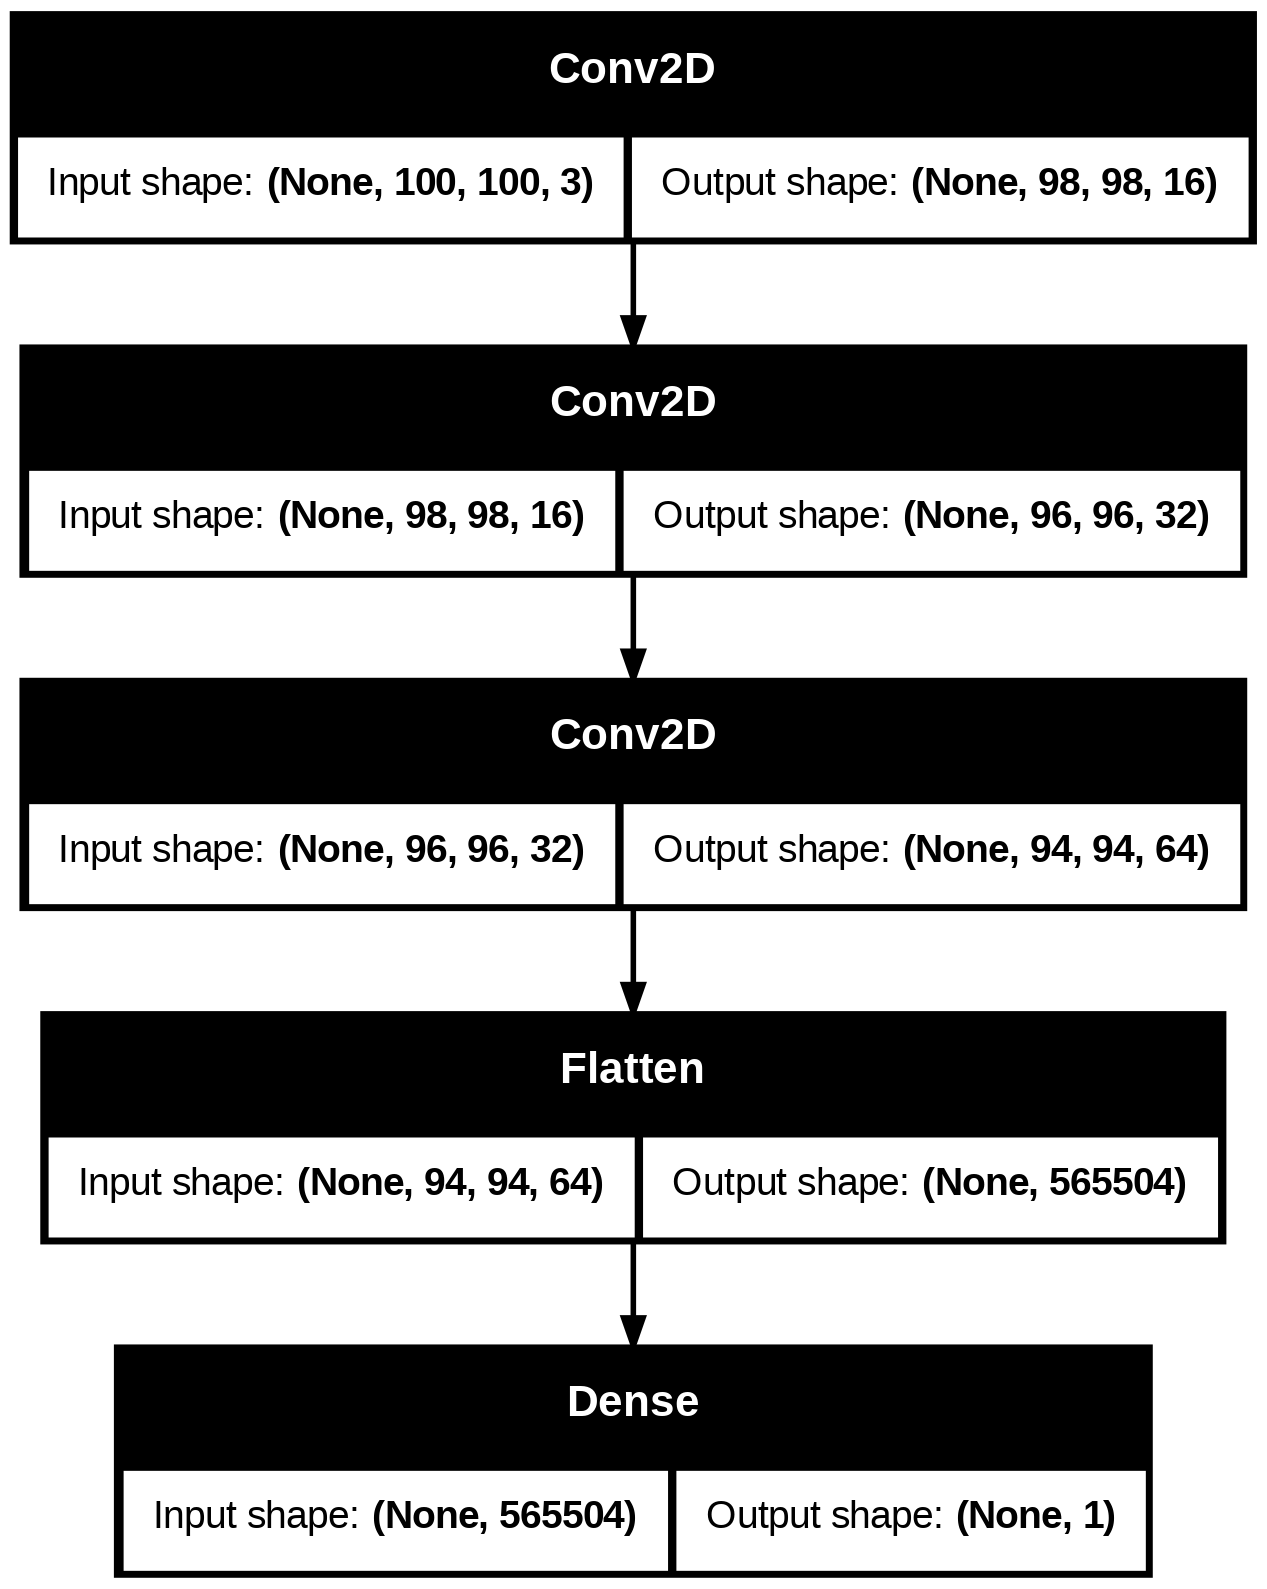

In [ ]:
tf.keras.utils.plot_model(discriminator, show_shapes=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(32)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


Model GAN dilatih menggunakan dataset gambar pistachio yang telah dinormalisasi dan dibagi dalam batch ukuran 32. Dataset ini dikonversi ke format tf.data.Dataset dan dishuffle untuk memastikan keragaman input selama training. Optimizer yang digunakan untuk generator dan discriminator adalah Adam dengan learning rate 1e-4, sesuai ketentuan soal. Fungsi aktivasi pada discriminator adalah ReLU, dan output akhir menggunakan sigmoid untuk klasifikasi real atau fake.

Loss function menggunakan binary crossentropy. Discriminator loss menghitung selisih antara prediksi terhadap gambar asli (diharapkan 1) dan gambar palsu (diharapkan 0), sementara generator loss berupaya memanipulasi discriminator agar menganggap gambar palsu sebagai asli (target 1). Semua setup ini sesuai spesifikasi soal, termasuk penggunaan optimizer, arsitektur, dan fungsi aktivasi yang diminta.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
@tf.function
def train_step(images, generator, discriminator):
    noise_dim = 100
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


Fungsi train_step di atas menjalankan satu langkah pelatihan GAN menggunakan @tf.function agar eksekusinya lebih cepat melalui graph mode. Di dalam fungsi ini, noise vektor acak berdimensi 100 dihasilkan sebagai input untuk generator. Generator lalu membuat gambar palsu, yang kemudian dievaluasi oleh discriminator bersama dengan gambar asli. Dua GradientTape digunakan secara paralel untuk menghitung loss dan menelusuri gradien dari masing-masing model.

Loss untuk generator dihitung berdasarkan seberapa baik ia berhasil "menipu" discriminator, sementara loss discriminator diukur dari kemampuannya membedakan gambar asli dan palsu. Setelah menghitung gradiennya, optimizer Adam yang sudah di-setup sebelumnya digunakan untuk memperbarui bobot kedua model. Fungsi ini menjadi bagian penting dari proses training loop GAN dan sudah sesuai dengan arsitektur serta tujuan yang diminta dalam soal.

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        image_rescaled = (predictions[i] + 1) / 2.0
        plt.imshow(image_rescaled)
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()


Kemudian saya membbuat training loop utama untuk model GAN. Setiap epoch, ia melakukan iterasi batch demi batch dari dataset, menjalankan train_step untuk memperbarui generator dan discriminator, lalu mencatat loss masing-masing. Di akhir epoch, rata-rata loss ditampilkan untuk memberikan gambaran performa model selama pelatihan. Agar proses monitoring lebih intuitif, model juga menghasilkan visualisasi gambar sintetis menggunakan noise tetap (seed) setiap 20 epoch atau di awal pelatihan.

Fungsi generate_and_save_images digunakan untuk menyimpan dan menampilkan gambar hasil prediksi generator. Gambar yang dihasilkan distandarisasi kembali dari range [-1, 1] ke [0, 1] agar dapat divisualisasikan dengan benar.




In [ ]:
def train(dataset, generator, discriminator, epochs, noise_dim=100):
    seed = tf.random.normal([16, noise_dim])
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        gen_losses = []
        disc_losses = []

        for batch in dataset:
            gen_loss, disc_loss = train_step(batch, generator, discriminator)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"Generator Loss: {np.mean(gen_losses):.4f}, Discriminator Loss: {np.mean(disc_losses):.4f}")

        if epoch % 20 == 0 or epoch == 1:
            generate_and_save_images(generator, epoch, seed)



Epoch 1/400
Generator Loss: 0.8085, Discriminator Loss: 0.6481


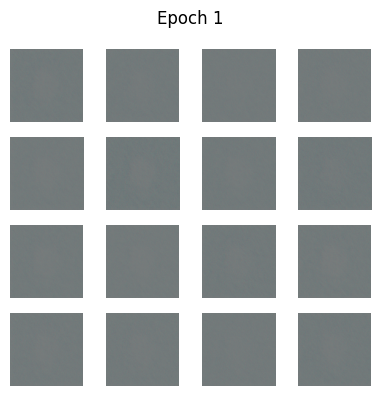


Epoch 2/400
Generator Loss: 2.9124, Discriminator Loss: 0.1061

Epoch 3/400
Generator Loss: 5.7182, Discriminator Loss: 0.0070

Epoch 4/400
Generator Loss: 6.6916, Discriminator Loss: 0.0050

Epoch 5/400
Generator Loss: 7.3133, Discriminator Loss: 0.0061

Epoch 6/400
Generator Loss: 6.2312, Discriminator Loss: 0.0552

Epoch 7/400
Generator Loss: 7.6061, Discriminator Loss: 0.1408

Epoch 8/400
Generator Loss: 2.7193, Discriminator Loss: 0.6915

Epoch 9/400
Generator Loss: 3.3135, Discriminator Loss: 1.0852

Epoch 10/400
Generator Loss: 2.7542, Discriminator Loss: 0.7787

Epoch 11/400
Generator Loss: 2.3444, Discriminator Loss: 1.1304

Epoch 12/400
Generator Loss: 3.9339, Discriminator Loss: 0.3584

Epoch 13/400
Generator Loss: 1.6546, Discriminator Loss: 1.8676

Epoch 14/400
Generator Loss: 2.6240, Discriminator Loss: 0.8055

Epoch 15/400
Generator Loss: 2.1570, Discriminator Loss: 0.9394

Epoch 16/400
Generator Loss: 1.2666, Discriminator Loss: 1.3679

Epoch 17/400
Generator Loss: 1.5

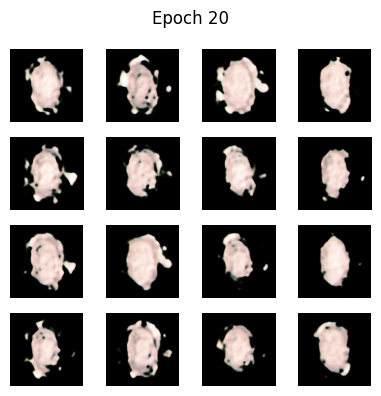


Epoch 21/400
Generator Loss: 2.1406, Discriminator Loss: 0.7587

Epoch 22/400
Generator Loss: 2.4442, Discriminator Loss: 0.6832

Epoch 23/400
Generator Loss: 2.1786, Discriminator Loss: 0.8776

Epoch 24/400
Generator Loss: 1.7520, Discriminator Loss: 0.9740

Epoch 25/400
Generator Loss: 1.6594, Discriminator Loss: 0.8768

Epoch 26/400
Generator Loss: 1.9457, Discriminator Loss: 0.7036

Epoch 27/400
Generator Loss: 1.8727, Discriminator Loss: 0.8221

Epoch 28/400
Generator Loss: 2.3586, Discriminator Loss: 0.5699

Epoch 29/400
Generator Loss: 2.1169, Discriminator Loss: 1.1283

Epoch 30/400
Generator Loss: 2.0739, Discriminator Loss: 0.7844

Epoch 31/400
Generator Loss: 1.5903, Discriminator Loss: 0.8379

Epoch 32/400
Generator Loss: 1.7933, Discriminator Loss: 0.7722

Epoch 33/400
Generator Loss: 2.3530, Discriminator Loss: 0.6130

Epoch 34/400
Generator Loss: 1.6034, Discriminator Loss: 1.1331

Epoch 35/400
Generator Loss: 1.9611, Discriminator Loss: 0.5523

Epoch 36/400
Generator L

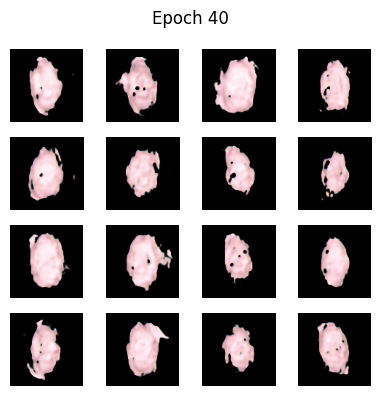


Epoch 41/400
Generator Loss: 2.2496, Discriminator Loss: 0.5772

Epoch 42/400
Generator Loss: 1.5962, Discriminator Loss: 0.8167

Epoch 43/400
Generator Loss: 1.4725, Discriminator Loss: 0.7361

Epoch 44/400
Generator Loss: 1.3436, Discriminator Loss: 0.9199

Epoch 45/400
Generator Loss: 1.1438, Discriminator Loss: 1.1445

Epoch 46/400
Generator Loss: 1.4377, Discriminator Loss: 0.7706

Epoch 47/400
Generator Loss: 1.0865, Discriminator Loss: 1.4608

Epoch 48/400
Generator Loss: 1.6309, Discriminator Loss: 0.8248

Epoch 49/400
Generator Loss: 1.6078, Discriminator Loss: 0.9220

Epoch 50/400
Generator Loss: 1.4851, Discriminator Loss: 0.8264

Epoch 51/400
Generator Loss: 1.3905, Discriminator Loss: 0.8938

Epoch 52/400
Generator Loss: 1.1709, Discriminator Loss: 1.0217

Epoch 53/400
Generator Loss: 1.3392, Discriminator Loss: 0.8512

Epoch 54/400
Generator Loss: 1.2413, Discriminator Loss: 0.9443

Epoch 55/400
Generator Loss: 1.2637, Discriminator Loss: 0.9191

Epoch 56/400
Generator L

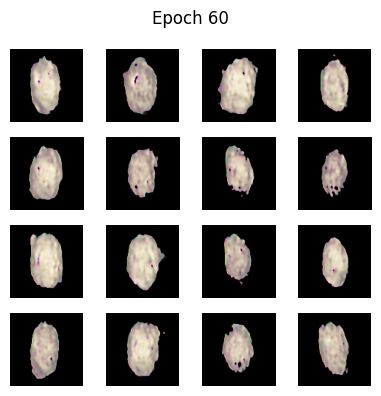


Epoch 61/400
Generator Loss: 1.3653, Discriminator Loss: 0.9826

Epoch 62/400
Generator Loss: 1.2642, Discriminator Loss: 1.0186

Epoch 63/400
Generator Loss: 1.3854, Discriminator Loss: 1.0113

Epoch 64/400
Generator Loss: 1.2229, Discriminator Loss: 1.0054

Epoch 65/400
Generator Loss: 1.3811, Discriminator Loss: 0.9892

Epoch 66/400
Generator Loss: 1.2744, Discriminator Loss: 1.0817

Epoch 67/400
Generator Loss: 1.3151, Discriminator Loss: 0.8787

Epoch 68/400
Generator Loss: 1.1118, Discriminator Loss: 1.1603

Epoch 69/400
Generator Loss: 1.4176, Discriminator Loss: 0.7651

Epoch 70/400
Generator Loss: 0.9897, Discriminator Loss: 1.2317

Epoch 71/400
Generator Loss: 1.2038, Discriminator Loss: 1.0199

Epoch 72/400
Generator Loss: 1.2518, Discriminator Loss: 0.9598

Epoch 73/400
Generator Loss: 1.2033, Discriminator Loss: 0.9991

Epoch 74/400
Generator Loss: 1.1962, Discriminator Loss: 1.0006

Epoch 75/400
Generator Loss: 1.3680, Discriminator Loss: 0.9635

Epoch 76/400
Generator L

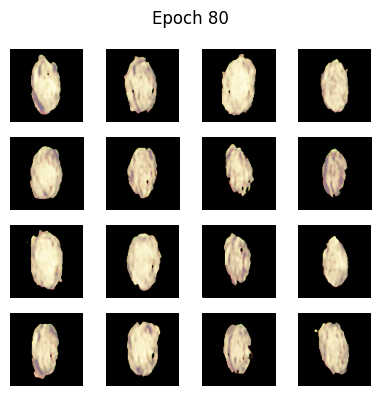


Epoch 81/400
Generator Loss: 1.3125, Discriminator Loss: 0.9734

Epoch 82/400
Generator Loss: 1.5428, Discriminator Loss: 0.8395

Epoch 83/400
Generator Loss: 1.5010, Discriminator Loss: 0.8774

Epoch 84/400
Generator Loss: 1.1271, Discriminator Loss: 1.2225

Epoch 85/400
Generator Loss: 1.4829, Discriminator Loss: 0.7587

Epoch 86/400
Generator Loss: 1.2322, Discriminator Loss: 0.9626

Epoch 87/400
Generator Loss: 1.1945, Discriminator Loss: 1.1350

Epoch 88/400
Generator Loss: 1.1561, Discriminator Loss: 1.0550

Epoch 89/400
Generator Loss: 1.0713, Discriminator Loss: 1.2929

Epoch 90/400
Generator Loss: 1.2628, Discriminator Loss: 0.9189

Epoch 91/400
Generator Loss: 1.2838, Discriminator Loss: 1.0923

Epoch 92/400
Generator Loss: 1.2812, Discriminator Loss: 1.0995

Epoch 93/400
Generator Loss: 1.7676, Discriminator Loss: 0.7252

Epoch 94/400
Generator Loss: 1.0670, Discriminator Loss: 1.2877

Epoch 95/400
Generator Loss: 1.2726, Discriminator Loss: 0.8569

Epoch 96/400
Generator L

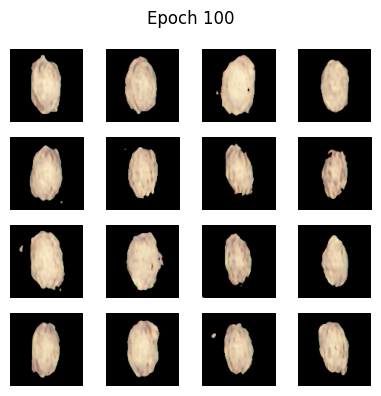


Epoch 101/400
Generator Loss: 1.2956, Discriminator Loss: 0.8203

Epoch 102/400
Generator Loss: 1.0357, Discriminator Loss: 1.2738

Epoch 103/400
Generator Loss: 1.6149, Discriminator Loss: 0.9240

Epoch 104/400
Generator Loss: 2.4609, Discriminator Loss: 0.7372

Epoch 105/400
Generator Loss: 1.7894, Discriminator Loss: 1.0150

Epoch 106/400
Generator Loss: 1.9792, Discriminator Loss: 0.7407

Epoch 107/400
Generator Loss: 1.0046, Discriminator Loss: 1.4297

Epoch 108/400
Generator Loss: 1.3428, Discriminator Loss: 1.0741

Epoch 109/400
Generator Loss: 1.3742, Discriminator Loss: 0.9641

Epoch 110/400
Generator Loss: 1.1761, Discriminator Loss: 1.0511

Epoch 111/400
Generator Loss: 1.4231, Discriminator Loss: 0.8052

Epoch 112/400
Generator Loss: 1.1060, Discriminator Loss: 1.2449

Epoch 113/400
Generator Loss: 1.5223, Discriminator Loss: 0.7105

Epoch 114/400
Generator Loss: 1.3488, Discriminator Loss: 0.8725

Epoch 115/400
Generator Loss: 1.3689, Discriminator Loss: 0.7601

Epoch 116

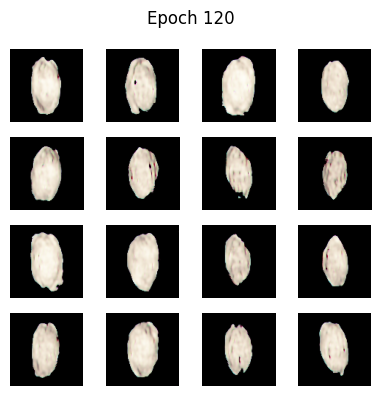


Epoch 121/400
Generator Loss: 1.1105, Discriminator Loss: 1.0056

Epoch 122/400
Generator Loss: 1.0069, Discriminator Loss: 1.1066

Epoch 123/400
Generator Loss: 1.0339, Discriminator Loss: 1.0715

Epoch 124/400
Generator Loss: 1.0674, Discriminator Loss: 1.0165

Epoch 125/400
Generator Loss: 1.1902, Discriminator Loss: 0.9289

Epoch 126/400
Generator Loss: 1.0259, Discriminator Loss: 1.1113

Epoch 127/400
Generator Loss: 1.0828, Discriminator Loss: 1.0999

Epoch 128/400
Generator Loss: 1.2219, Discriminator Loss: 1.1190

Epoch 129/400
Generator Loss: 1.3327, Discriminator Loss: 0.8685

Epoch 130/400
Generator Loss: 1.2082, Discriminator Loss: 1.2296

Epoch 131/400
Generator Loss: 1.1335, Discriminator Loss: 1.3223

Epoch 132/400
Generator Loss: 1.7713, Discriminator Loss: 0.6017

Epoch 133/400
Generator Loss: 1.1456, Discriminator Loss: 1.2526

Epoch 134/400
Generator Loss: 1.0317, Discriminator Loss: 1.3857

Epoch 135/400
Generator Loss: 1.1342, Discriminator Loss: 1.1789

Epoch 136

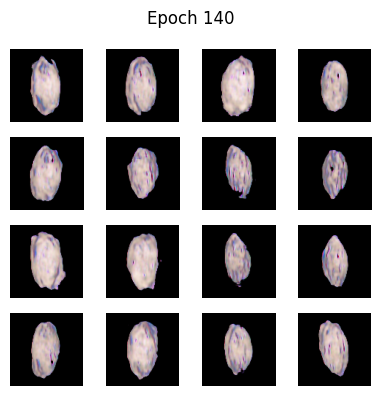


Epoch 141/400
Generator Loss: 1.1844, Discriminator Loss: 1.1208

Epoch 142/400
Generator Loss: 0.9420, Discriminator Loss: 1.3807

Epoch 143/400
Generator Loss: 1.1145, Discriminator Loss: 1.0782

Epoch 144/400
Generator Loss: 0.9286, Discriminator Loss: 1.3055

Epoch 145/400
Generator Loss: 1.1513, Discriminator Loss: 1.0602

Epoch 146/400
Generator Loss: 1.0336, Discriminator Loss: 1.1466

Epoch 147/400
Generator Loss: 1.0000, Discriminator Loss: 1.1355

Epoch 148/400
Generator Loss: 1.0066, Discriminator Loss: 1.0777

Epoch 149/400
Generator Loss: 0.9690, Discriminator Loss: 1.0967

Epoch 150/400
Generator Loss: 0.9522, Discriminator Loss: 1.1128

Epoch 151/400
Generator Loss: 0.9301, Discriminator Loss: 1.2068

Epoch 152/400
Generator Loss: 0.9303, Discriminator Loss: 1.1612

Epoch 153/400
Generator Loss: 0.9995, Discriminator Loss: 1.0914

Epoch 154/400
Generator Loss: 0.9986, Discriminator Loss: 1.0858

Epoch 155/400
Generator Loss: 1.0419, Discriminator Loss: 1.0199

Epoch 156

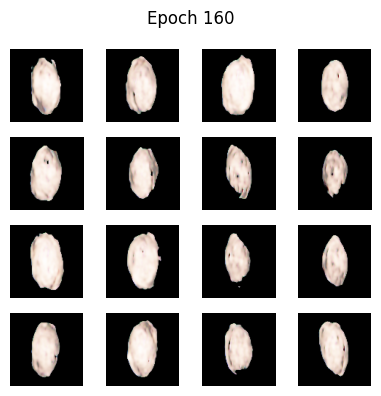


Epoch 161/400
Generator Loss: 1.0751, Discriminator Loss: 1.1365

Epoch 162/400
Generator Loss: 0.9842, Discriminator Loss: 1.1083

Epoch 163/400
Generator Loss: 1.2305, Discriminator Loss: 0.9873

Epoch 164/400
Generator Loss: 1.1214, Discriminator Loss: 1.0867

Epoch 165/400
Generator Loss: 1.1810, Discriminator Loss: 0.9571

Epoch 166/400
Generator Loss: 1.0969, Discriminator Loss: 1.0868

Epoch 167/400
Generator Loss: 0.8849, Discriminator Loss: 1.2576

Epoch 168/400
Generator Loss: 1.0601, Discriminator Loss: 0.9935

Epoch 169/400
Generator Loss: 1.1382, Discriminator Loss: 0.9778

Epoch 170/400
Generator Loss: 1.0978, Discriminator Loss: 1.1192

Epoch 171/400
Generator Loss: 1.1679, Discriminator Loss: 0.9626

Epoch 172/400
Generator Loss: 0.9896, Discriminator Loss: 1.1181

Epoch 173/400
Generator Loss: 0.9461, Discriminator Loss: 1.1312

Epoch 174/400
Generator Loss: 1.0865, Discriminator Loss: 0.9785

Epoch 175/400
Generator Loss: 1.0986, Discriminator Loss: 1.0034

Epoch 176

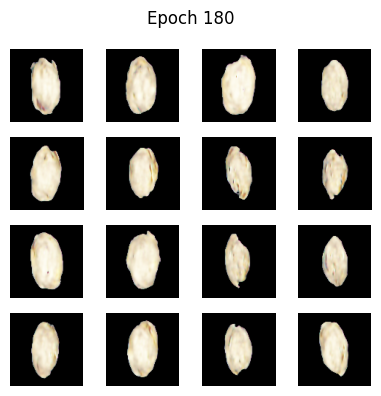


Epoch 181/400
Generator Loss: 1.1110, Discriminator Loss: 1.0031

Epoch 182/400
Generator Loss: 1.1583, Discriminator Loss: 1.0127

Epoch 183/400
Generator Loss: 1.2160, Discriminator Loss: 0.9037

Epoch 184/400
Generator Loss: 1.1648, Discriminator Loss: 1.0812

Epoch 185/400
Generator Loss: 1.0581, Discriminator Loss: 1.0235

Epoch 186/400
Generator Loss: 1.1361, Discriminator Loss: 0.9868

Epoch 187/400
Generator Loss: 1.0397, Discriminator Loss: 1.0703

Epoch 188/400
Generator Loss: 1.0314, Discriminator Loss: 1.1223

Epoch 189/400
Generator Loss: 1.1965, Discriminator Loss: 1.0153

Epoch 190/400
Generator Loss: 1.1291, Discriminator Loss: 1.1269

Epoch 191/400
Generator Loss: 1.1780, Discriminator Loss: 0.9507

Epoch 192/400
Generator Loss: 1.2592, Discriminator Loss: 1.2567

Epoch 193/400
Generator Loss: 1.0653, Discriminator Loss: 1.2106

Epoch 194/400
Generator Loss: 1.0487, Discriminator Loss: 1.0782

Epoch 195/400
Generator Loss: 1.0135, Discriminator Loss: 1.0619

Epoch 196

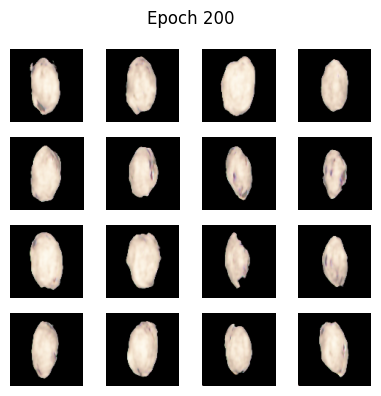


Epoch 201/400
Generator Loss: 1.2756, Discriminator Loss: 0.9489

Epoch 202/400
Generator Loss: 1.2040, Discriminator Loss: 1.0004

Epoch 203/400
Generator Loss: 1.1256, Discriminator Loss: 1.0537

Epoch 204/400
Generator Loss: 1.1317, Discriminator Loss: 0.9811

Epoch 205/400
Generator Loss: 0.9238, Discriminator Loss: 1.2703

Epoch 206/400
Generator Loss: 1.1803, Discriminator Loss: 1.0557

Epoch 207/400
Generator Loss: 1.1207, Discriminator Loss: 1.1080

Epoch 208/400
Generator Loss: 1.4457, Discriminator Loss: 1.1964

Epoch 209/400
Generator Loss: 1.3512, Discriminator Loss: 0.9583

Epoch 210/400
Generator Loss: 0.9941, Discriminator Loss: 1.3716

Epoch 211/400
Generator Loss: 1.1824, Discriminator Loss: 0.9114

Epoch 212/400
Generator Loss: 1.4253, Discriminator Loss: 0.7794

Epoch 213/400
Generator Loss: 1.3628, Discriminator Loss: 1.1001

Epoch 214/400
Generator Loss: 1.3688, Discriminator Loss: 0.9760

Epoch 215/400
Generator Loss: 1.1619, Discriminator Loss: 0.9677

Epoch 216

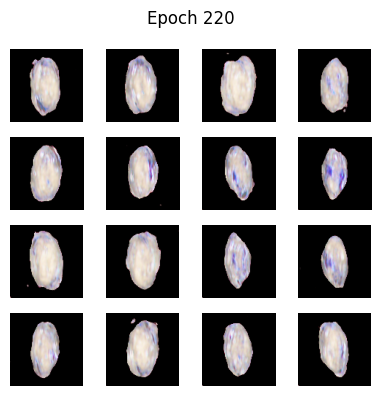


Epoch 221/400
Generator Loss: 1.0979, Discriminator Loss: 1.1371

Epoch 222/400
Generator Loss: 0.9580, Discriminator Loss: 1.2871

Epoch 223/400
Generator Loss: 1.3330, Discriminator Loss: 0.8277

Epoch 224/400
Generator Loss: 1.1165, Discriminator Loss: 1.1270

Epoch 225/400
Generator Loss: 1.4108, Discriminator Loss: 0.9207

Epoch 226/400
Generator Loss: 1.2509, Discriminator Loss: 0.8774

Epoch 227/400
Generator Loss: 1.1347, Discriminator Loss: 1.0081

Epoch 228/400
Generator Loss: 0.9941, Discriminator Loss: 1.0973

Epoch 229/400
Generator Loss: 1.0530, Discriminator Loss: 1.0168

Epoch 230/400
Generator Loss: 1.1331, Discriminator Loss: 0.9562

Epoch 231/400
Generator Loss: 1.1830, Discriminator Loss: 0.9824

Epoch 232/400
Generator Loss: 1.0811, Discriminator Loss: 1.0333

Epoch 233/400
Generator Loss: 1.0427, Discriminator Loss: 1.0551

Epoch 234/400
Generator Loss: 1.0238, Discriminator Loss: 1.0608

Epoch 235/400
Generator Loss: 1.0795, Discriminator Loss: 1.0064

Epoch 236

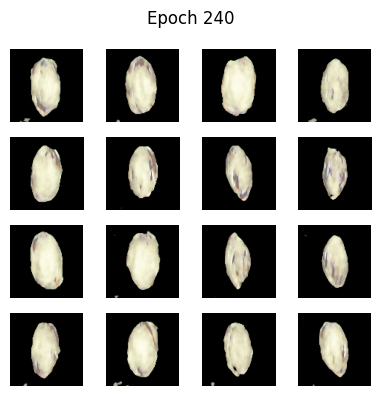


Epoch 241/400
Generator Loss: 1.1454, Discriminator Loss: 0.9488

Epoch 242/400
Generator Loss: 1.1419, Discriminator Loss: 1.0138

Epoch 243/400
Generator Loss: 1.1105, Discriminator Loss: 1.0111

Epoch 244/400
Generator Loss: 0.8940, Discriminator Loss: 1.2029

Epoch 245/400
Generator Loss: 1.1518, Discriminator Loss: 0.9029

Epoch 246/400
Generator Loss: 1.0774, Discriminator Loss: 1.1562

Epoch 247/400
Generator Loss: 1.3953, Discriminator Loss: 0.7751

Epoch 248/400
Generator Loss: 1.1373, Discriminator Loss: 1.1644

Epoch 249/400
Generator Loss: 1.0283, Discriminator Loss: 1.1832

Epoch 250/400
Generator Loss: 1.3876, Discriminator Loss: 0.9485

Epoch 251/400
Generator Loss: 1.5470, Discriminator Loss: 0.7977

Epoch 252/400
Generator Loss: 1.2407, Discriminator Loss: 1.0488

Epoch 253/400
Generator Loss: 1.1408, Discriminator Loss: 1.0272

Epoch 254/400
Generator Loss: 1.1821, Discriminator Loss: 1.0980

Epoch 255/400
Generator Loss: 1.3564, Discriminator Loss: 1.0302

Epoch 256

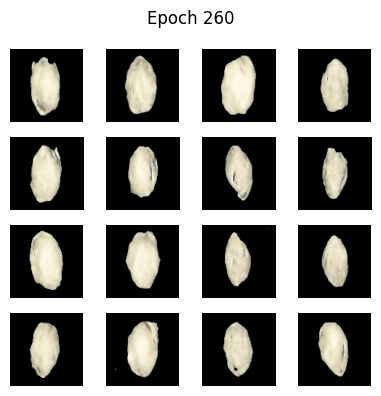


Epoch 261/400
Generator Loss: 1.0938, Discriminator Loss: 1.1073

Epoch 262/400
Generator Loss: 1.1144, Discriminator Loss: 1.1117

Epoch 263/400
Generator Loss: 1.0970, Discriminator Loss: 1.0279

Epoch 264/400
Generator Loss: 1.0905, Discriminator Loss: 0.9883

Epoch 265/400
Generator Loss: 1.0380, Discriminator Loss: 1.0978

Epoch 266/400
Generator Loss: 1.0571, Discriminator Loss: 1.0293

Epoch 267/400
Generator Loss: 1.0697, Discriminator Loss: 1.0781

Epoch 268/400
Generator Loss: 1.2036, Discriminator Loss: 0.9876

Epoch 269/400
Generator Loss: 1.0297, Discriminator Loss: 1.1287

Epoch 270/400
Generator Loss: 1.1238, Discriminator Loss: 1.0086

Epoch 271/400
Generator Loss: 1.2316, Discriminator Loss: 0.9685

Epoch 272/400
Generator Loss: 1.1483, Discriminator Loss: 1.2002

Epoch 273/400
Generator Loss: 1.4426, Discriminator Loss: 1.0984

Epoch 274/400
Generator Loss: 0.9433, Discriminator Loss: 1.4184

Epoch 275/400
Generator Loss: 0.9904, Discriminator Loss: 1.0942

Epoch 276

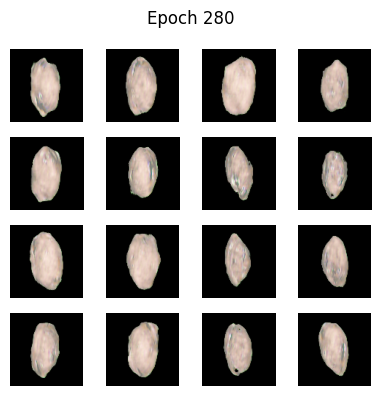


Epoch 281/400
Generator Loss: 1.0467, Discriminator Loss: 1.0964

Epoch 282/400
Generator Loss: 1.1640, Discriminator Loss: 1.0164

Epoch 283/400
Generator Loss: 1.6233, Discriminator Loss: 0.7260

Epoch 284/400
Generator Loss: 1.7320, Discriminator Loss: 0.8664

Epoch 285/400
Generator Loss: 1.0648, Discriminator Loss: 1.3128

Epoch 286/400
Generator Loss: 1.0708, Discriminator Loss: 1.0181

Epoch 287/400
Generator Loss: 1.1324, Discriminator Loss: 0.9090

Epoch 288/400
Generator Loss: 1.0979, Discriminator Loss: 1.0540

Epoch 289/400
Generator Loss: 1.1300, Discriminator Loss: 1.0056

Epoch 290/400
Generator Loss: 1.0805, Discriminator Loss: 1.0072

Epoch 291/400
Generator Loss: 1.0630, Discriminator Loss: 1.0918

Epoch 292/400
Generator Loss: 0.9659, Discriminator Loss: 1.1630

Epoch 293/400
Generator Loss: 1.1014, Discriminator Loss: 0.9707

Epoch 294/400
Generator Loss: 1.0812, Discriminator Loss: 1.0315

Epoch 295/400
Generator Loss: 1.2127, Discriminator Loss: 0.9162

Epoch 296

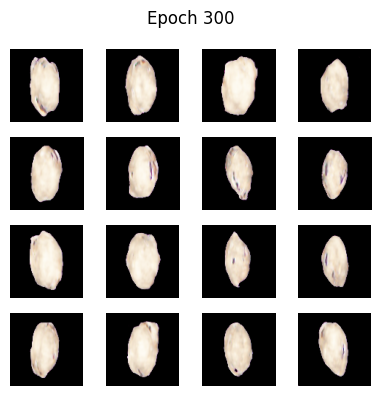


Epoch 301/400
Generator Loss: 1.1600, Discriminator Loss: 1.0608

Epoch 302/400
Generator Loss: 1.0104, Discriminator Loss: 1.0448

Epoch 303/400
Generator Loss: 1.0729, Discriminator Loss: 1.0120

Epoch 304/400
Generator Loss: 0.9801, Discriminator Loss: 1.0805

Epoch 305/400
Generator Loss: 0.9453, Discriminator Loss: 1.0811

Epoch 306/400
Generator Loss: 1.0165, Discriminator Loss: 0.9948

Epoch 307/400
Generator Loss: 0.9817, Discriminator Loss: 1.1457

Epoch 308/400
Generator Loss: 1.1833, Discriminator Loss: 0.9573

Epoch 309/400
Generator Loss: 1.0596, Discriminator Loss: 1.0375

Epoch 310/400
Generator Loss: 1.0107, Discriminator Loss: 1.0455

Epoch 311/400
Generator Loss: 0.9982, Discriminator Loss: 1.1032

Epoch 312/400
Generator Loss: 1.2376, Discriminator Loss: 0.8703

Epoch 313/400
Generator Loss: 1.1043, Discriminator Loss: 1.0613

Epoch 314/400
Generator Loss: 1.1273, Discriminator Loss: 0.9920

Epoch 315/400
Generator Loss: 1.1076, Discriminator Loss: 1.0774

Epoch 316

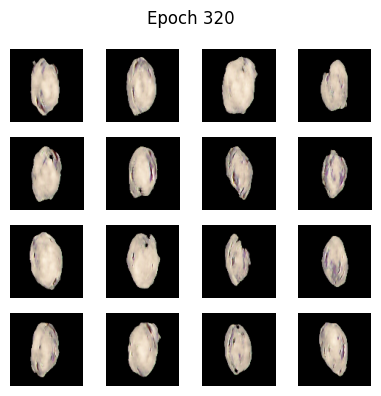


Epoch 321/400
Generator Loss: 1.1075, Discriminator Loss: 1.1748

Epoch 322/400
Generator Loss: 1.0407, Discriminator Loss: 1.1236

Epoch 323/400
Generator Loss: 1.1804, Discriminator Loss: 1.0026

Epoch 324/400
Generator Loss: 1.0008, Discriminator Loss: 1.0990

Epoch 325/400
Generator Loss: 1.0300, Discriminator Loss: 1.0751

Epoch 326/400
Generator Loss: 1.1266, Discriminator Loss: 0.9684

Epoch 327/400
Generator Loss: 0.9983, Discriminator Loss: 1.1020

Epoch 328/400
Generator Loss: 0.9943, Discriminator Loss: 1.0535

Epoch 329/400
Generator Loss: 0.9880, Discriminator Loss: 1.1144

Epoch 330/400
Generator Loss: 1.1241, Discriminator Loss: 1.0003

Epoch 331/400
Generator Loss: 0.9937, Discriminator Loss: 1.1603

Epoch 332/400
Generator Loss: 1.1153, Discriminator Loss: 0.9316

Epoch 333/400
Generator Loss: 0.9423, Discriminator Loss: 1.2291

Epoch 334/400
Generator Loss: 1.3251, Discriminator Loss: 0.8045

Epoch 335/400
Generator Loss: 1.1059, Discriminator Loss: 1.1093

Epoch 336

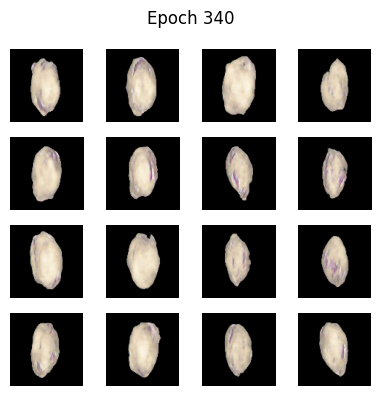


Epoch 341/400
Generator Loss: 1.0858, Discriminator Loss: 0.9542

Epoch 342/400
Generator Loss: 1.1334, Discriminator Loss: 0.9875

Epoch 343/400
Generator Loss: 1.1137, Discriminator Loss: 1.0339

Epoch 344/400
Generator Loss: 1.1757, Discriminator Loss: 0.9426

Epoch 345/400
Generator Loss: 0.9729, Discriminator Loss: 1.1162

Epoch 346/400
Generator Loss: 1.0808, Discriminator Loss: 0.9603

Epoch 347/400
Generator Loss: 1.1986, Discriminator Loss: 0.8942

Epoch 348/400
Generator Loss: 1.0222, Discriminator Loss: 1.0922

Epoch 349/400
Generator Loss: 1.1253, Discriminator Loss: 0.9884

Epoch 350/400
Generator Loss: 1.0400, Discriminator Loss: 1.0006

Epoch 351/400
Generator Loss: 1.1556, Discriminator Loss: 0.8927

Epoch 352/400
Generator Loss: 1.1247, Discriminator Loss: 1.0482

Epoch 353/400
Generator Loss: 1.2013, Discriminator Loss: 1.0360

Epoch 354/400
Generator Loss: 1.1978, Discriminator Loss: 0.9450

Epoch 355/400
Generator Loss: 1.1482, Discriminator Loss: 1.0348

Epoch 356

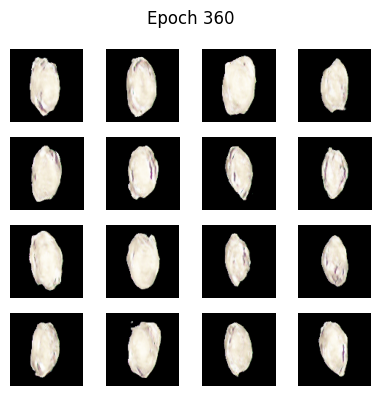


Epoch 361/400
Generator Loss: 1.1296, Discriminator Loss: 1.0860

Epoch 362/400
Generator Loss: 1.2545, Discriminator Loss: 1.0003

Epoch 363/400
Generator Loss: 1.1645, Discriminator Loss: 0.9052

Epoch 364/400
Generator Loss: 1.0318, Discriminator Loss: 1.0263

Epoch 365/400
Generator Loss: 1.1114, Discriminator Loss: 0.9944

Epoch 366/400
Generator Loss: 1.1503, Discriminator Loss: 1.0136

Epoch 367/400
Generator Loss: 1.1734, Discriminator Loss: 0.9117

Epoch 368/400
Generator Loss: 1.0943, Discriminator Loss: 1.0279

Epoch 369/400
Generator Loss: 1.0358, Discriminator Loss: 1.0135

Epoch 370/400
Generator Loss: 1.0843, Discriminator Loss: 0.9439

Epoch 371/400
Generator Loss: 1.1104, Discriminator Loss: 1.0142

Epoch 372/400
Generator Loss: 1.2661, Discriminator Loss: 0.9419

Epoch 373/400
Generator Loss: 1.0735, Discriminator Loss: 1.0258

Epoch 374/400
Generator Loss: 1.1000, Discriminator Loss: 0.9444

Epoch 375/400
Generator Loss: 1.0380, Discriminator Loss: 1.0066

Epoch 376

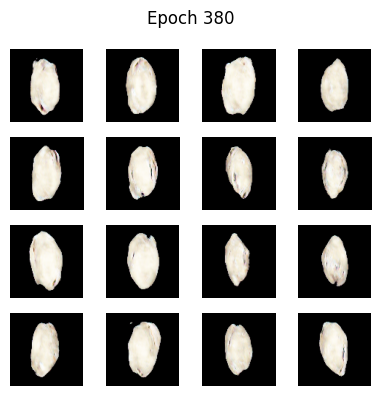


Epoch 381/400
Generator Loss: 1.2039, Discriminator Loss: 0.9158

Epoch 382/400
Generator Loss: 1.0617, Discriminator Loss: 1.0557

Epoch 383/400
Generator Loss: 1.0578, Discriminator Loss: 0.9630

Epoch 384/400
Generator Loss: 1.1015, Discriminator Loss: 0.9494

Epoch 385/400
Generator Loss: 1.1862, Discriminator Loss: 0.8924

Epoch 386/400
Generator Loss: 1.0659, Discriminator Loss: 0.9992

Epoch 387/400
Generator Loss: 1.1415, Discriminator Loss: 0.9040

Epoch 388/400
Generator Loss: 1.0469, Discriminator Loss: 1.0279

Epoch 389/400
Generator Loss: 1.1940, Discriminator Loss: 0.8535

Epoch 390/400
Generator Loss: 1.0381, Discriminator Loss: 1.0551

Epoch 391/400
Generator Loss: 1.1437, Discriminator Loss: 0.8660

Epoch 392/400
Generator Loss: 1.1132, Discriminator Loss: 0.9676

Epoch 393/400
Generator Loss: 1.1863, Discriminator Loss: 0.9346

Epoch 394/400
Generator Loss: 1.1455, Discriminator Loss: 0.9774

Epoch 395/400
Generator Loss: 1.1980, Discriminator Loss: 0.8499

Epoch 396

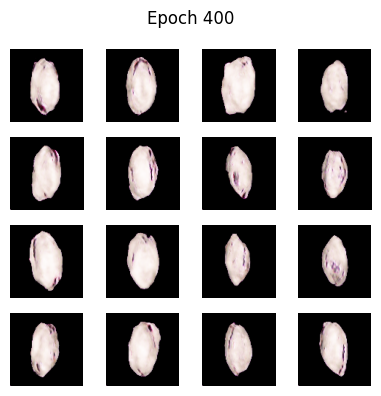

In [ ]:
train(train_dataset, generator, discriminator, epochs=400)


Epoch 1/20
Generator Loss: 1.2208, Discriminator Loss: 0.8998


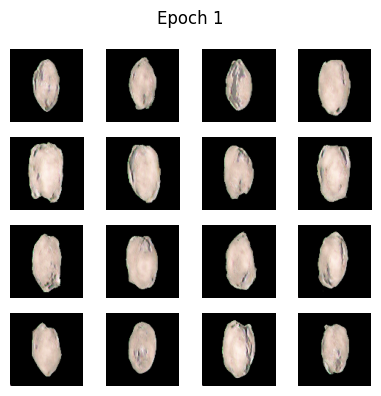


Epoch 2/20
Generator Loss: 1.2068, Discriminator Loss: 0.9661

Epoch 3/20
Generator Loss: 1.0058, Discriminator Loss: 1.0616

Epoch 4/20
Generator Loss: 1.3930, Discriminator Loss: 0.7343

Epoch 5/20
Generator Loss: 1.2501, Discriminator Loss: 0.9461

Epoch 6/20
Generator Loss: 1.2284, Discriminator Loss: 0.9540

Epoch 7/20
Generator Loss: 1.2413, Discriminator Loss: 0.7901

Epoch 8/20
Generator Loss: 1.1882, Discriminator Loss: 0.8484

Epoch 9/20
Generator Loss: 1.1473, Discriminator Loss: 0.9486

Epoch 10/20
Generator Loss: 1.2017, Discriminator Loss: 0.9227

Epoch 11/20
Generator Loss: 1.1979, Discriminator Loss: 0.8729

Epoch 12/20
Generator Loss: 1.1182, Discriminator Loss: 0.9184

Epoch 13/20
Generator Loss: 1.1346, Discriminator Loss: 0.9210

Epoch 14/20
Generator Loss: 1.2077, Discriminator Loss: 0.8623

Epoch 15/20
Generator Loss: 1.2666, Discriminator Loss: 0.9152

Epoch 16/20
Generator Loss: 1.0946, Discriminator Loss: 1.0719

Epoch 17/20
Generator Loss: 1.2802, Discriminat

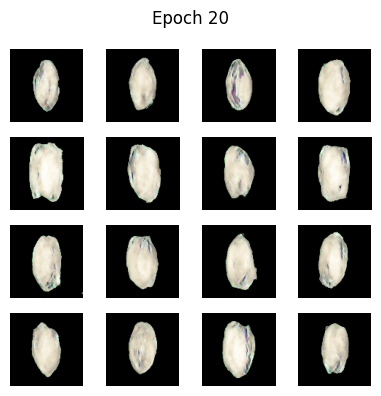

In [ ]:
train(train_dataset, generator, discriminator, epochs=20)

## B. Modified GAN

In [ ]:
def build_generator2():
    model = tf.keras.Sequential([
        layers.Input(shape=(100,)),
        layers.Dense(106 * 106 * 64, use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),
        layers.Reshape((106, 106, 64)),

        layers.Conv2D(128, (3, 3), strides=1, padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2D(64, (3, 3), strides=1, padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2D(32, (3, 3), strides=1, padding='valid', use_bias=False),
        layers.BatchNormalization(),
        layers.ReLU(),

        layers.Conv2D(3, (1, 1), strides=1, padding='valid', activation='tanh')
    ])
    return model


Pada build_generator2, saya menambahkan batch normalization setelah setiap convolutional layer, yang membantu menstabilkan proses pelatihan dan mempercepat konvergensi. Selain itu, ukuran filter diperbesar secara bertahap dari 128 ke 32, memungkinkan model membentuk representasi fitur kompleks secara lebih bertahap sebelum menghasilkan output akhir berukuran 100x100x3 dengan aktivasi tanh.

Untuk build_discriminator2, say: mengganti padding menjadi 'same' dan menambahkan LeakyReLU serta dropout di tiap layer. LeakyReLU mencegah masalah "dead neuron" dan dropout bertindak sebagai regularisasi agar discriminator tidak terlalu cepat mengungguli generator. Dengan arsitektur ini, discriminator dapat lebih efisien dalam membedakan antara gambar asli dan hasil sintesis, sementara generator memiliki kapasitas yang lebih kuat untuk belajar representasi distribusi data target.


In [ ]:
def build_discriminator2():
    model = tf.keras.Sequential([
        layers.Input(shape=(100, 100, 3)),

        layers.Conv2D(32, (3, 3), strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(64, (3, 3), strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3, 3), strides=2, padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
generator_optimizer2 = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer2 = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)

@tf.function
def train_step2(images, generator, discriminator):
    noise_dim = 100
    noise = tf.random.normal([images.shape[0], noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer2.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer2.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


Untuk training model GAN modifikasi, saya menggunakan learning rate yang lebih kecil dan momentum yang disesuaikan melalui beta=0.5 agar training lebih stabil. Proses train_step2 pada dasarnya masih mengikuti alur dasar GAN: generator menghasilkan gambar dari noise, lalu discriminator menilai gambar nyata dan palsu. Kedua loss dihitung menggunakan binary_crossentropy, lalu gradiennya dipakai untuk memperbarui parameter masing-masing model.

In [ ]:
def train2(dataset, generator, discriminator, epochs, noise_dim=100):
    print("Training Modified GAN...")
    seed = tf.random.normal([16, noise_dim])
    for epoch in range(1, epochs + 1):
        gen_losses = []
        disc_losses = []

        for batch in dataset:
            gen_loss, disc_loss = train_step2(batch, generator, discriminator)
            gen_losses.append(gen_loss)
            disc_losses.append(disc_loss)

        print(f"[Modified] Epoch {epoch}/{epochs} | Gen Loss: {np.mean(gen_losses):.4f} | Disc Loss: {np.mean(disc_losses):.4f}")
        if epoch % 20 == 0 or epoch == 1:
            generate_and_save_images(generator, epoch, seed)


In [ ]:
generator2 = build_generator2()
discriminator2 = build_discriminator2()

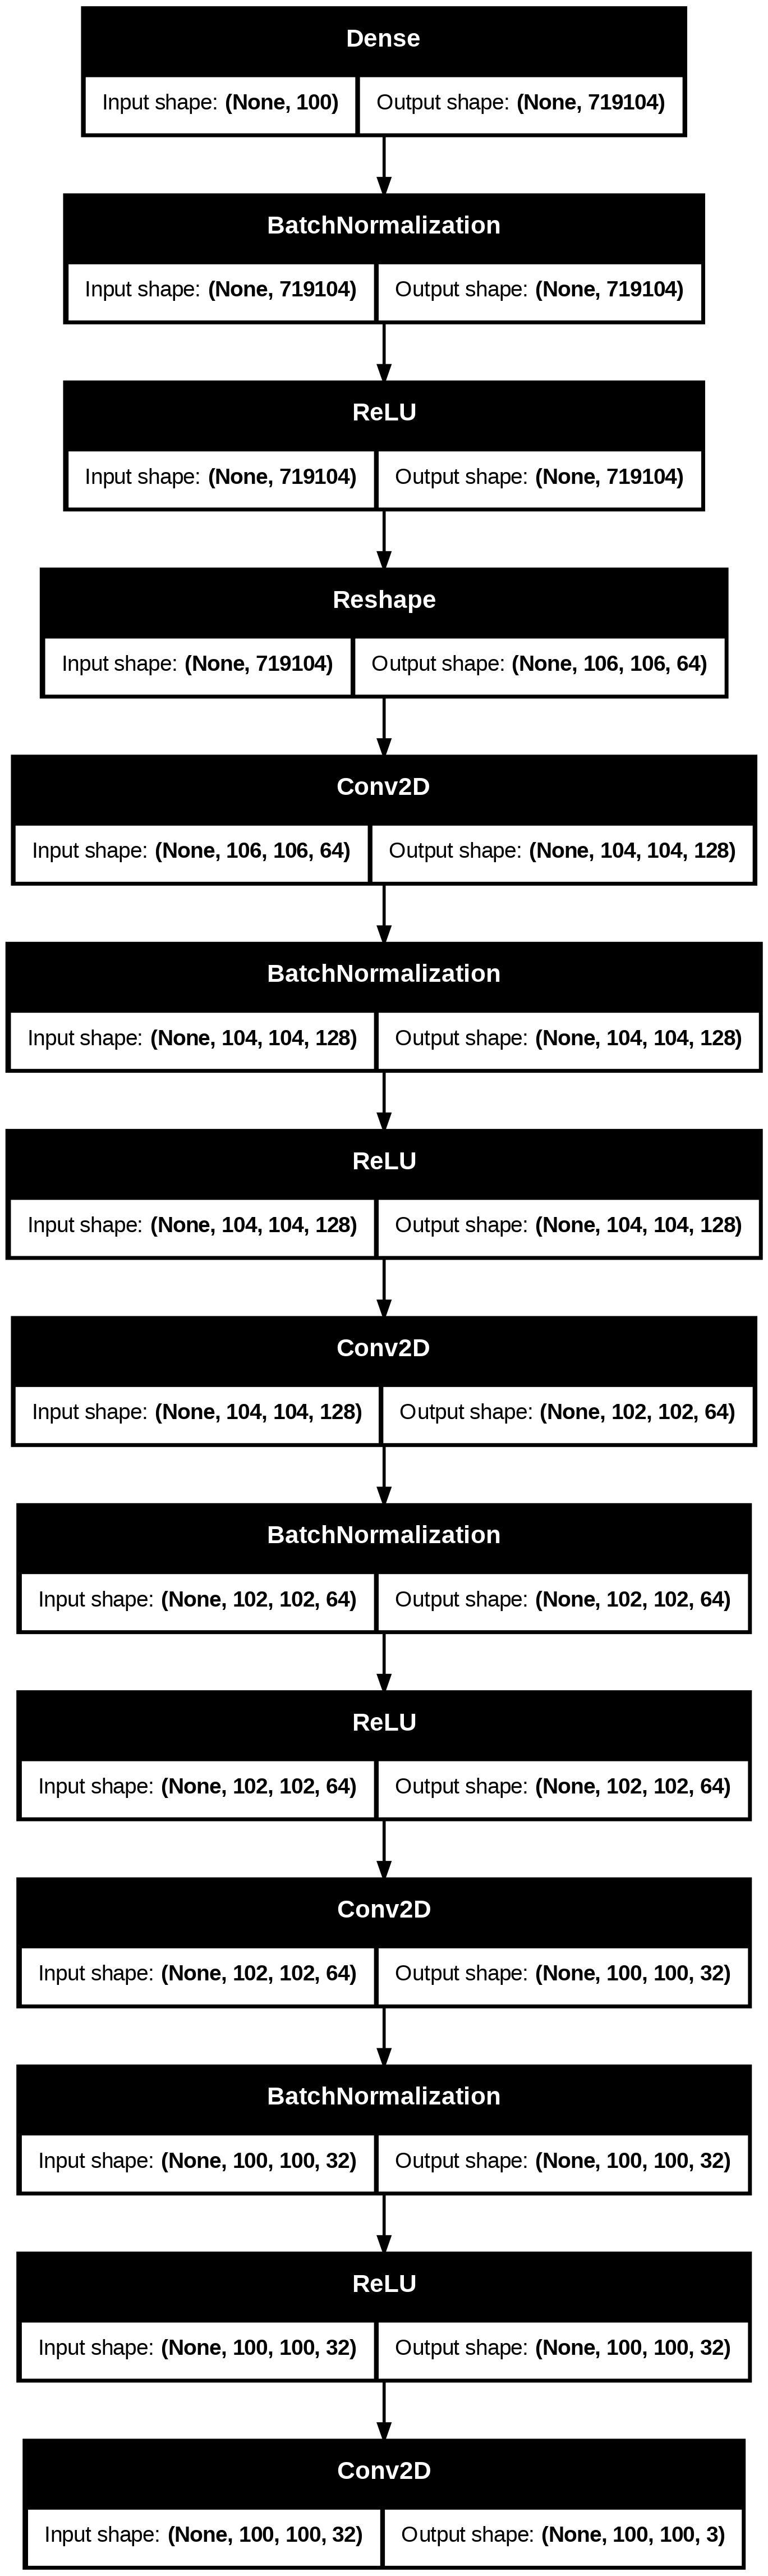

In [ ]:
tf.keras.utils.plot_model(generator2, show_shapes=True)

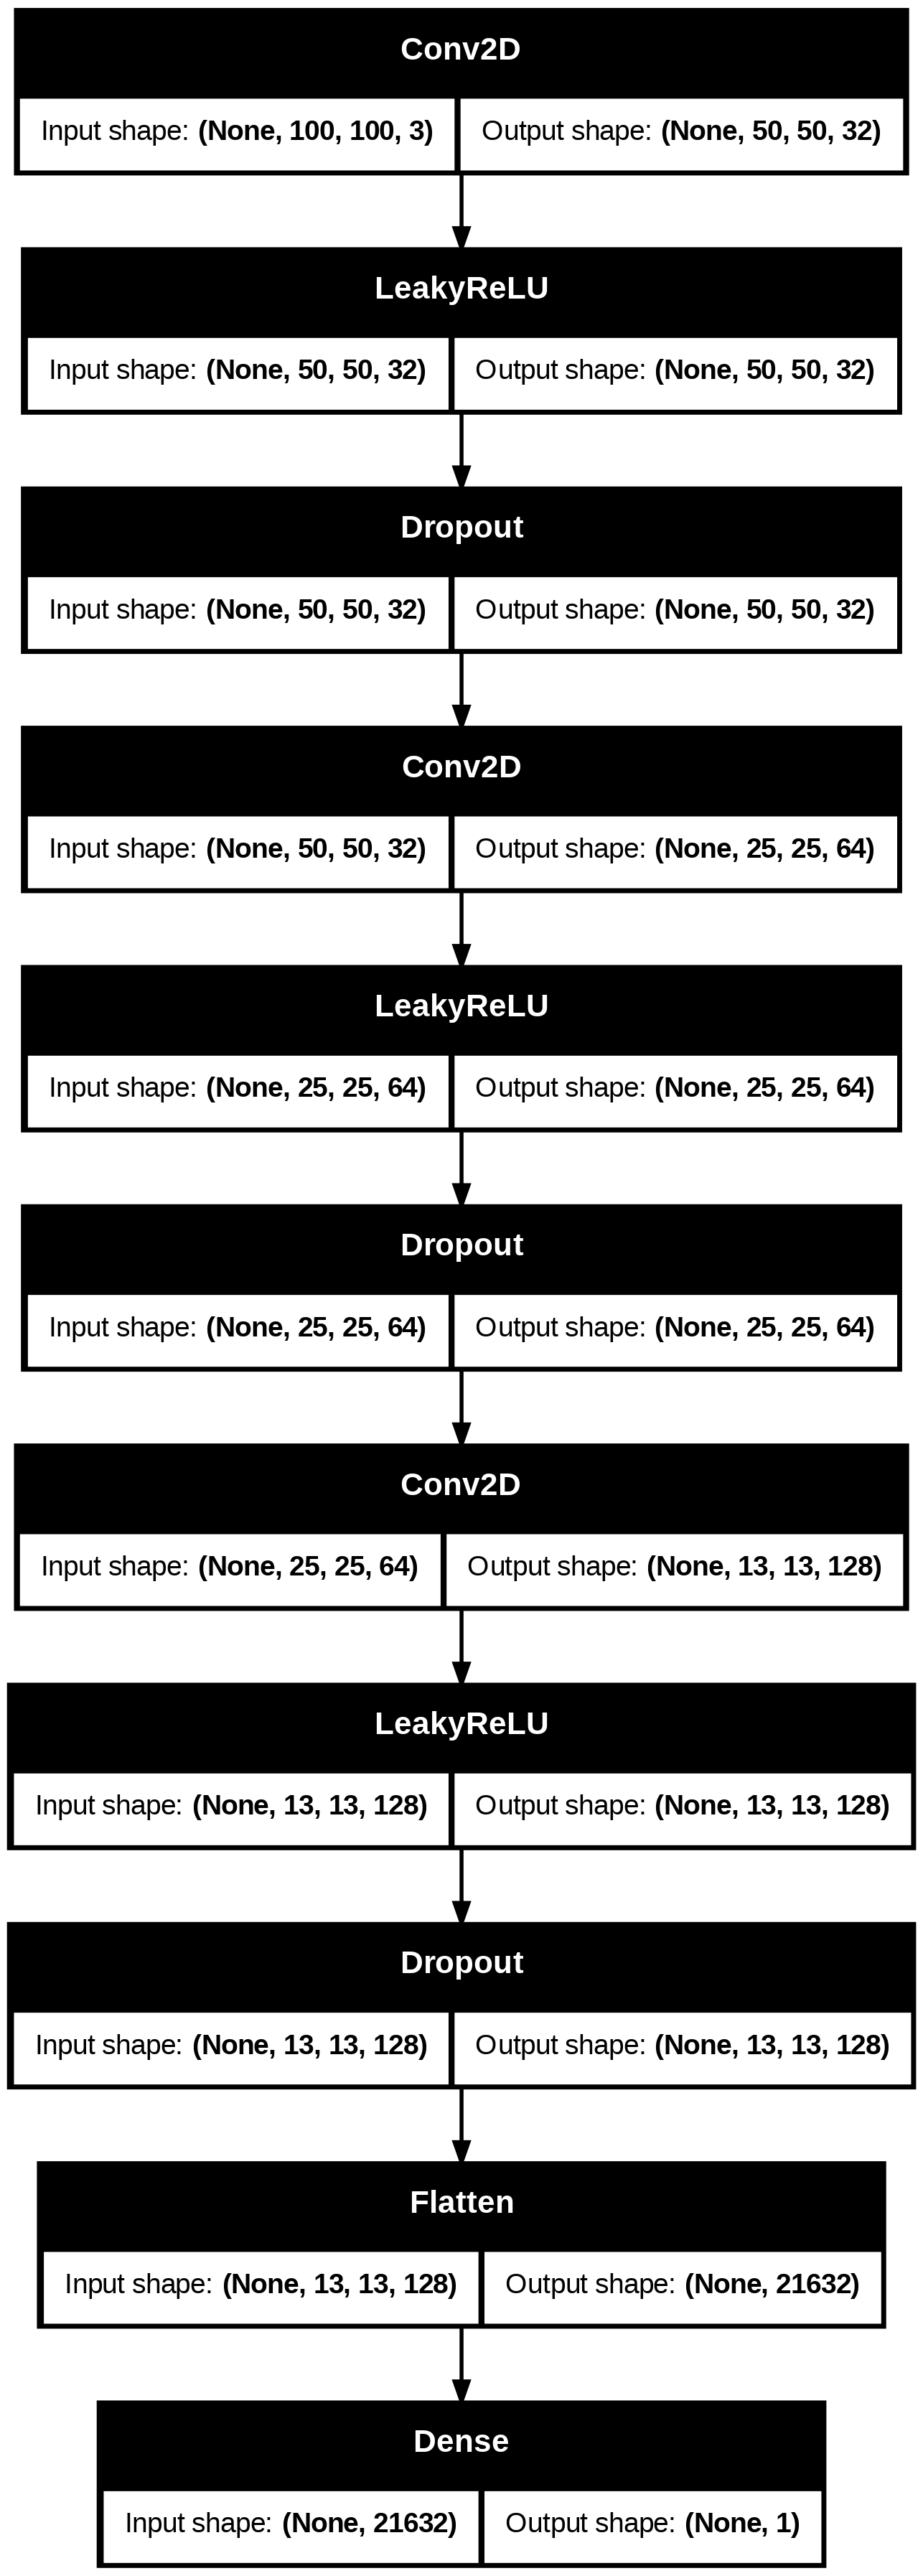

In [ ]:
tf.keras.utils.plot_model(discriminator2, show_shapes=True)

Training Modified GAN...


E0000 00:00:1750943222.917008      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_16_1/dropout_12_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


[Modified] Epoch 1/400 | Gen Loss: 1.3094 | Disc Loss: 0.6810


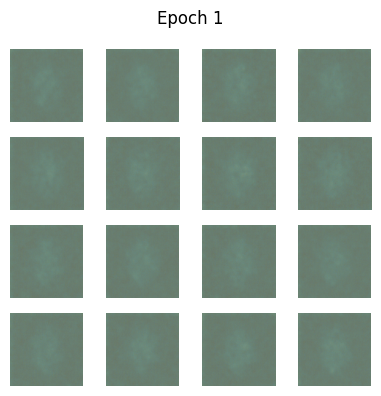

[Modified] Epoch 2/400 | Gen Loss: 1.7863 | Disc Loss: 0.5222
[Modified] Epoch 3/400 | Gen Loss: 1.3183 | Disc Loss: 0.7904
[Modified] Epoch 4/400 | Gen Loss: 1.0181 | Disc Loss: 1.0905
[Modified] Epoch 5/400 | Gen Loss: 0.9985 | Disc Loss: 1.0845
[Modified] Epoch 6/400 | Gen Loss: 1.0122 | Disc Loss: 1.1421
[Modified] Epoch 7/400 | Gen Loss: 0.9986 | Disc Loss: 1.0937
[Modified] Epoch 8/400 | Gen Loss: 0.9947 | Disc Loss: 1.1455
[Modified] Epoch 9/400 | Gen Loss: 0.9787 | Disc Loss: 1.1218
[Modified] Epoch 10/400 | Gen Loss: 1.0014 | Disc Loss: 1.1493
[Modified] Epoch 11/400 | Gen Loss: 1.0161 | Disc Loss: 1.1811
[Modified] Epoch 12/400 | Gen Loss: 0.9340 | Disc Loss: 1.1979
[Modified] Epoch 13/400 | Gen Loss: 0.9201 | Disc Loss: 1.2257
[Modified] Epoch 14/400 | Gen Loss: 0.9297 | Disc Loss: 1.2215
[Modified] Epoch 15/400 | Gen Loss: 0.9198 | Disc Loss: 1.2330
[Modified] Epoch 16/400 | Gen Loss: 0.9180 | Disc Loss: 1.2794
[Modified] Epoch 17/400 | Gen Loss: 0.8664 | Disc Loss: 1.3048


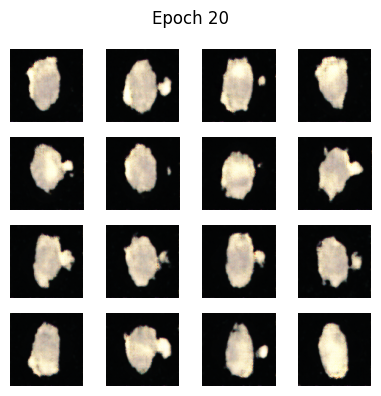

[Modified] Epoch 21/400 | Gen Loss: 0.8311 | Disc Loss: 1.3876
[Modified] Epoch 22/400 | Gen Loss: 0.7976 | Disc Loss: 1.3409
[Modified] Epoch 23/400 | Gen Loss: 0.7677 | Disc Loss: 1.3815
[Modified] Epoch 24/400 | Gen Loss: 0.7876 | Disc Loss: 1.3425
[Modified] Epoch 25/400 | Gen Loss: 0.7968 | Disc Loss: 1.3282
[Modified] Epoch 26/400 | Gen Loss: 0.7573 | Disc Loss: 1.3801
[Modified] Epoch 27/400 | Gen Loss: 0.7773 | Disc Loss: 1.3860
[Modified] Epoch 28/400 | Gen Loss: 0.7524 | Disc Loss: 1.3417
[Modified] Epoch 29/400 | Gen Loss: 0.7767 | Disc Loss: 1.3765
[Modified] Epoch 30/400 | Gen Loss: 0.7470 | Disc Loss: 1.3858
[Modified] Epoch 31/400 | Gen Loss: 0.7690 | Disc Loss: 1.3588
[Modified] Epoch 32/400 | Gen Loss: 0.7385 | Disc Loss: 1.3864
[Modified] Epoch 33/400 | Gen Loss: 0.7603 | Disc Loss: 1.3584
[Modified] Epoch 34/400 | Gen Loss: 0.7217 | Disc Loss: 1.3805
[Modified] Epoch 35/400 | Gen Loss: 0.7453 | Disc Loss: 1.3764
[Modified] Epoch 36/400 | Gen Loss: 0.7421 | Disc Loss:

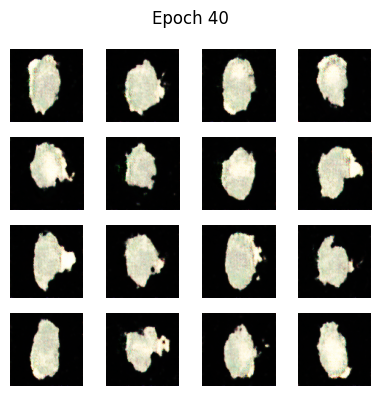

[Modified] Epoch 41/400 | Gen Loss: 0.7255 | Disc Loss: 1.3713
[Modified] Epoch 42/400 | Gen Loss: 0.7184 | Disc Loss: 1.3729
[Modified] Epoch 43/400 | Gen Loss: 0.7289 | Disc Loss: 1.3773
[Modified] Epoch 44/400 | Gen Loss: 0.7346 | Disc Loss: 1.3892
[Modified] Epoch 45/400 | Gen Loss: 0.7144 | Disc Loss: 1.3891
[Modified] Epoch 46/400 | Gen Loss: 0.7263 | Disc Loss: 1.3664
[Modified] Epoch 47/400 | Gen Loss: 0.7106 | Disc Loss: 1.3890
[Modified] Epoch 48/400 | Gen Loss: 0.7193 | Disc Loss: 1.3847
[Modified] Epoch 49/400 | Gen Loss: 0.7189 | Disc Loss: 1.3817
[Modified] Epoch 50/400 | Gen Loss: 0.7214 | Disc Loss: 1.3839
[Modified] Epoch 51/400 | Gen Loss: 0.7151 | Disc Loss: 1.3757
[Modified] Epoch 52/400 | Gen Loss: 0.7165 | Disc Loss: 1.3894
[Modified] Epoch 53/400 | Gen Loss: 0.7113 | Disc Loss: 1.3809
[Modified] Epoch 54/400 | Gen Loss: 0.7252 | Disc Loss: 1.3921
[Modified] Epoch 55/400 | Gen Loss: 0.7107 | Disc Loss: 1.3753
[Modified] Epoch 56/400 | Gen Loss: 0.7155 | Disc Loss:

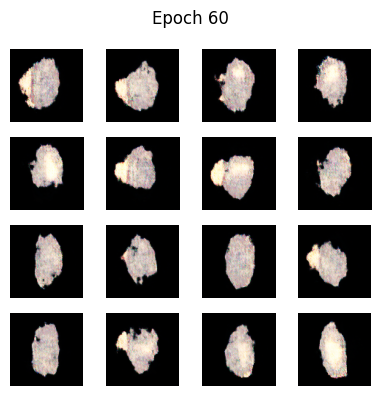

[Modified] Epoch 61/400 | Gen Loss: 0.7173 | Disc Loss: 1.3800
[Modified] Epoch 62/400 | Gen Loss: 0.7114 | Disc Loss: 1.3872
[Modified] Epoch 63/400 | Gen Loss: 0.7050 | Disc Loss: 1.3864
[Modified] Epoch 64/400 | Gen Loss: 0.7123 | Disc Loss: 1.3860
[Modified] Epoch 65/400 | Gen Loss: 0.7055 | Disc Loss: 1.3845
[Modified] Epoch 66/400 | Gen Loss: 0.7150 | Disc Loss: 1.3873
[Modified] Epoch 67/400 | Gen Loss: 0.7084 | Disc Loss: 1.3828
[Modified] Epoch 68/400 | Gen Loss: 0.7087 | Disc Loss: 1.3840
[Modified] Epoch 69/400 | Gen Loss: 0.7091 | Disc Loss: 1.3745
[Modified] Epoch 70/400 | Gen Loss: 0.7106 | Disc Loss: 1.3926
[Modified] Epoch 71/400 | Gen Loss: 0.7061 | Disc Loss: 1.3810
[Modified] Epoch 72/400 | Gen Loss: 0.7097 | Disc Loss: 1.3784
[Modified] Epoch 73/400 | Gen Loss: 0.7037 | Disc Loss: 1.3881
[Modified] Epoch 74/400 | Gen Loss: 0.7113 | Disc Loss: 1.3705
[Modified] Epoch 75/400 | Gen Loss: 0.6996 | Disc Loss: 1.3966
[Modified] Epoch 76/400 | Gen Loss: 0.7102 | Disc Loss:

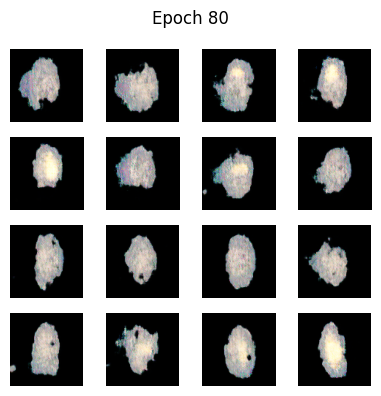

[Modified] Epoch 81/400 | Gen Loss: 0.7080 | Disc Loss: 1.3795
[Modified] Epoch 82/400 | Gen Loss: 0.7058 | Disc Loss: 1.3852
[Modified] Epoch 83/400 | Gen Loss: 0.7053 | Disc Loss: 1.3842
[Modified] Epoch 84/400 | Gen Loss: 0.7059 | Disc Loss: 1.3823
[Modified] Epoch 85/400 | Gen Loss: 0.7040 | Disc Loss: 1.3878
[Modified] Epoch 86/400 | Gen Loss: 0.7086 | Disc Loss: 1.3751
[Modified] Epoch 87/400 | Gen Loss: 0.7057 | Disc Loss: 1.3858
[Modified] Epoch 88/400 | Gen Loss: 0.7058 | Disc Loss: 1.3801
[Modified] Epoch 89/400 | Gen Loss: 0.7122 | Disc Loss: 1.3935
[Modified] Epoch 90/400 | Gen Loss: 0.7064 | Disc Loss: 1.3864
[Modified] Epoch 91/400 | Gen Loss: 0.7061 | Disc Loss: 1.3785
[Modified] Epoch 92/400 | Gen Loss: 0.7018 | Disc Loss: 1.3818
[Modified] Epoch 93/400 | Gen Loss: 0.7056 | Disc Loss: 1.3820
[Modified] Epoch 94/400 | Gen Loss: 0.7060 | Disc Loss: 1.3911
[Modified] Epoch 95/400 | Gen Loss: 0.7033 | Disc Loss: 1.3860
[Modified] Epoch 96/400 | Gen Loss: 0.7033 | Disc Loss:

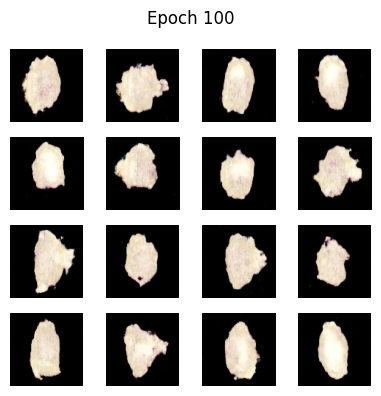

[Modified] Epoch 101/400 | Gen Loss: 0.7014 | Disc Loss: 1.3863
[Modified] Epoch 102/400 | Gen Loss: 0.7092 | Disc Loss: 1.3749
[Modified] Epoch 103/400 | Gen Loss: 0.7028 | Disc Loss: 1.3955
[Modified] Epoch 104/400 | Gen Loss: 0.7144 | Disc Loss: 1.3728
[Modified] Epoch 105/400 | Gen Loss: 0.6959 | Disc Loss: 1.3866
[Modified] Epoch 106/400 | Gen Loss: 0.7116 | Disc Loss: 1.3730
[Modified] Epoch 107/400 | Gen Loss: 0.6978 | Disc Loss: 1.3869
[Modified] Epoch 108/400 | Gen Loss: 0.7085 | Disc Loss: 1.3810
[Modified] Epoch 109/400 | Gen Loss: 0.7018 | Disc Loss: 1.3845
[Modified] Epoch 110/400 | Gen Loss: 0.7014 | Disc Loss: 1.3844
[Modified] Epoch 111/400 | Gen Loss: 0.7070 | Disc Loss: 1.3805
[Modified] Epoch 112/400 | Gen Loss: 0.6995 | Disc Loss: 1.3819
[Modified] Epoch 113/400 | Gen Loss: 0.7072 | Disc Loss: 1.3855
[Modified] Epoch 114/400 | Gen Loss: 0.7050 | Disc Loss: 1.3909
[Modified] Epoch 115/400 | Gen Loss: 0.7056 | Disc Loss: 1.3744
[Modified] Epoch 116/400 | Gen Loss: 0.7

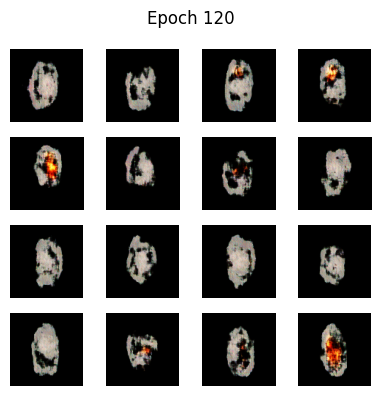

[Modified] Epoch 121/400 | Gen Loss: 0.7019 | Disc Loss: 1.3787
[Modified] Epoch 122/400 | Gen Loss: 0.7137 | Disc Loss: 1.3848
[Modified] Epoch 123/400 | Gen Loss: 0.7047 | Disc Loss: 1.3841
[Modified] Epoch 124/400 | Gen Loss: 0.6963 | Disc Loss: 1.3855
[Modified] Epoch 125/400 | Gen Loss: 0.6991 | Disc Loss: 1.3778
[Modified] Epoch 126/400 | Gen Loss: 0.7093 | Disc Loss: 1.3748
[Modified] Epoch 127/400 | Gen Loss: 0.7111 | Disc Loss: 1.3853
[Modified] Epoch 128/400 | Gen Loss: 0.7032 | Disc Loss: 1.3728
[Modified] Epoch 129/400 | Gen Loss: 0.7027 | Disc Loss: 1.3848
[Modified] Epoch 130/400 | Gen Loss: 0.7047 | Disc Loss: 1.3776
[Modified] Epoch 131/400 | Gen Loss: 0.7042 | Disc Loss: 1.3867
[Modified] Epoch 132/400 | Gen Loss: 0.7067 | Disc Loss: 1.3741
[Modified] Epoch 133/400 | Gen Loss: 0.7085 | Disc Loss: 1.3880
[Modified] Epoch 134/400 | Gen Loss: 0.7031 | Disc Loss: 1.3782
[Modified] Epoch 135/400 | Gen Loss: 0.7049 | Disc Loss: 1.3749
[Modified] Epoch 136/400 | Gen Loss: 0.7

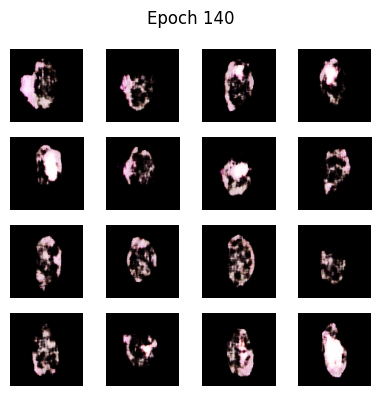

[Modified] Epoch 141/400 | Gen Loss: 0.7078 | Disc Loss: 1.3854
[Modified] Epoch 142/400 | Gen Loss: 0.7086 | Disc Loss: 1.3767
[Modified] Epoch 143/400 | Gen Loss: 0.7007 | Disc Loss: 1.3758
[Modified] Epoch 144/400 | Gen Loss: 0.7131 | Disc Loss: 1.3840
[Modified] Epoch 145/400 | Gen Loss: 0.7036 | Disc Loss: 1.3781
[Modified] Epoch 146/400 | Gen Loss: 0.7069 | Disc Loss: 1.3807
[Modified] Epoch 147/400 | Gen Loss: 0.7107 | Disc Loss: 1.3747
[Modified] Epoch 148/400 | Gen Loss: 0.7057 | Disc Loss: 1.3818
[Modified] Epoch 149/400 | Gen Loss: 0.7008 | Disc Loss: 1.3740
[Modified] Epoch 150/400 | Gen Loss: 0.7090 | Disc Loss: 1.3856
[Modified] Epoch 151/400 | Gen Loss: 0.7001 | Disc Loss: 1.3752
[Modified] Epoch 152/400 | Gen Loss: 0.7090 | Disc Loss: 1.3765
[Modified] Epoch 153/400 | Gen Loss: 0.7061 | Disc Loss: 1.3783
[Modified] Epoch 154/400 | Gen Loss: 0.7086 | Disc Loss: 1.3640
[Modified] Epoch 155/400 | Gen Loss: 0.7016 | Disc Loss: 1.3906
[Modified] Epoch 156/400 | Gen Loss: 0.7

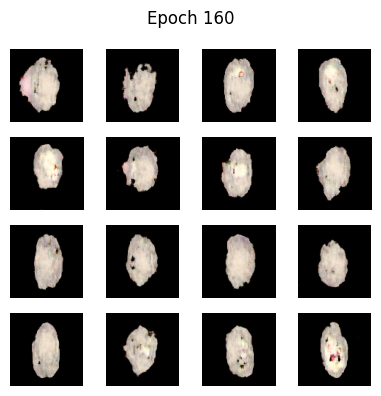

[Modified] Epoch 161/400 | Gen Loss: 0.7031 | Disc Loss: 1.3781
[Modified] Epoch 162/400 | Gen Loss: 0.7078 | Disc Loss: 1.3706
[Modified] Epoch 163/400 | Gen Loss: 0.7107 | Disc Loss: 1.3738
[Modified] Epoch 164/400 | Gen Loss: 0.7172 | Disc Loss: 1.3717
[Modified] Epoch 165/400 | Gen Loss: 0.7070 | Disc Loss: 1.3699
[Modified] Epoch 166/400 | Gen Loss: 0.7067 | Disc Loss: 1.3738
[Modified] Epoch 167/400 | Gen Loss: 0.7198 | Disc Loss: 1.3719
[Modified] Epoch 168/400 | Gen Loss: 0.7161 | Disc Loss: 1.3646
[Modified] Epoch 169/400 | Gen Loss: 0.7111 | Disc Loss: 1.3786
[Modified] Epoch 170/400 | Gen Loss: 0.7188 | Disc Loss: 1.3700
[Modified] Epoch 171/400 | Gen Loss: 0.7317 | Disc Loss: 1.3599
[Modified] Epoch 172/400 | Gen Loss: 0.7037 | Disc Loss: 1.3741
[Modified] Epoch 173/400 | Gen Loss: 0.7237 | Disc Loss: 1.3598
[Modified] Epoch 174/400 | Gen Loss: 0.7155 | Disc Loss: 1.3730
[Modified] Epoch 175/400 | Gen Loss: 0.7056 | Disc Loss: 1.3705
[Modified] Epoch 176/400 | Gen Loss: 0.7

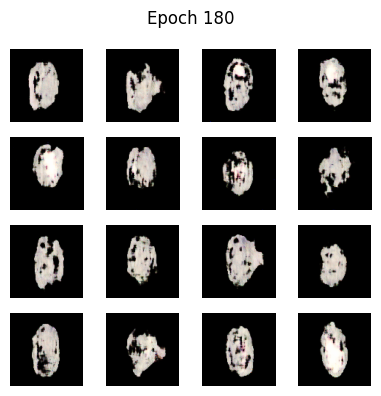

[Modified] Epoch 181/400 | Gen Loss: 0.7082 | Disc Loss: 1.3764
[Modified] Epoch 182/400 | Gen Loss: 0.7200 | Disc Loss: 1.3736
[Modified] Epoch 183/400 | Gen Loss: 0.7176 | Disc Loss: 1.3630
[Modified] Epoch 184/400 | Gen Loss: 0.7114 | Disc Loss: 1.3743
[Modified] Epoch 185/400 | Gen Loss: 0.7086 | Disc Loss: 1.3680
[Modified] Epoch 186/400 | Gen Loss: 0.7236 | Disc Loss: 1.3612
[Modified] Epoch 187/400 | Gen Loss: 0.7157 | Disc Loss: 1.3703
[Modified] Epoch 188/400 | Gen Loss: 0.7142 | Disc Loss: 1.3659
[Modified] Epoch 189/400 | Gen Loss: 0.7152 | Disc Loss: 1.3696
[Modified] Epoch 190/400 | Gen Loss: 0.7168 | Disc Loss: 1.3643
[Modified] Epoch 191/400 | Gen Loss: 0.7200 | Disc Loss: 1.3626
[Modified] Epoch 192/400 | Gen Loss: 0.7220 | Disc Loss: 1.3507
[Modified] Epoch 193/400 | Gen Loss: 0.7148 | Disc Loss: 1.3784
[Modified] Epoch 194/400 | Gen Loss: 0.7294 | Disc Loss: 1.3682
[Modified] Epoch 195/400 | Gen Loss: 0.7430 | Disc Loss: 1.3519
[Modified] Epoch 196/400 | Gen Loss: 0.7

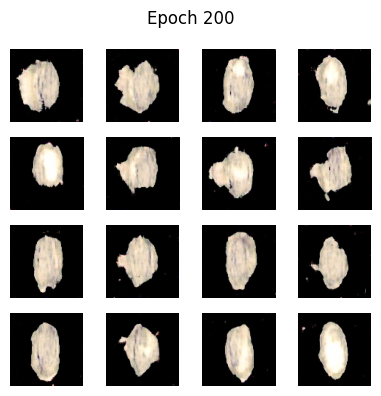

[Modified] Epoch 201/400 | Gen Loss: 0.7248 | Disc Loss: 1.3520
[Modified] Epoch 202/400 | Gen Loss: 0.7316 | Disc Loss: 1.3510
[Modified] Epoch 203/400 | Gen Loss: 0.7177 | Disc Loss: 1.3711
[Modified] Epoch 204/400 | Gen Loss: 0.7255 | Disc Loss: 1.3586
[Modified] Epoch 205/400 | Gen Loss: 0.7177 | Disc Loss: 1.3553
[Modified] Epoch 206/400 | Gen Loss: 0.7415 | Disc Loss: 1.3452
[Modified] Epoch 207/400 | Gen Loss: 0.7249 | Disc Loss: 1.3590
[Modified] Epoch 208/400 | Gen Loss: 0.7353 | Disc Loss: 1.3439
[Modified] Epoch 209/400 | Gen Loss: 0.7277 | Disc Loss: 1.3557
[Modified] Epoch 210/400 | Gen Loss: 0.7367 | Disc Loss: 1.3351
[Modified] Epoch 211/400 | Gen Loss: 0.7258 | Disc Loss: 1.3661
[Modified] Epoch 212/400 | Gen Loss: 0.7336 | Disc Loss: 1.3521
[Modified] Epoch 213/400 | Gen Loss: 0.7313 | Disc Loss: 1.3502
[Modified] Epoch 214/400 | Gen Loss: 0.7343 | Disc Loss: 1.3690
[Modified] Epoch 215/400 | Gen Loss: 0.7249 | Disc Loss: 1.3547
[Modified] Epoch 216/400 | Gen Loss: 0.7

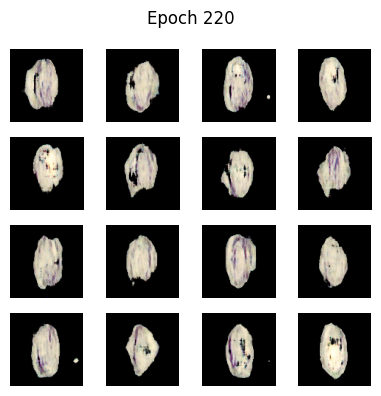

[Modified] Epoch 221/400 | Gen Loss: 0.7419 | Disc Loss: 1.3464
[Modified] Epoch 222/400 | Gen Loss: 0.7257 | Disc Loss: 1.3561
[Modified] Epoch 223/400 | Gen Loss: 0.7421 | Disc Loss: 1.3357
[Modified] Epoch 224/400 | Gen Loss: 0.7450 | Disc Loss: 1.3317
[Modified] Epoch 225/400 | Gen Loss: 0.7328 | Disc Loss: 1.3619
[Modified] Epoch 226/400 | Gen Loss: 0.7356 | Disc Loss: 1.3435
[Modified] Epoch 227/400 | Gen Loss: 0.7468 | Disc Loss: 1.3585
[Modified] Epoch 228/400 | Gen Loss: 0.7230 | Disc Loss: 1.3437
[Modified] Epoch 229/400 | Gen Loss: 0.7426 | Disc Loss: 1.3482
[Modified] Epoch 230/400 | Gen Loss: 0.7471 | Disc Loss: 1.3260
[Modified] Epoch 231/400 | Gen Loss: 0.7347 | Disc Loss: 1.3468
[Modified] Epoch 232/400 | Gen Loss: 0.7514 | Disc Loss: 1.3312
[Modified] Epoch 233/400 | Gen Loss: 0.7375 | Disc Loss: 1.3380
[Modified] Epoch 234/400 | Gen Loss: 0.7441 | Disc Loss: 1.3496
[Modified] Epoch 235/400 | Gen Loss: 0.7367 | Disc Loss: 1.3415
[Modified] Epoch 236/400 | Gen Loss: 0.7

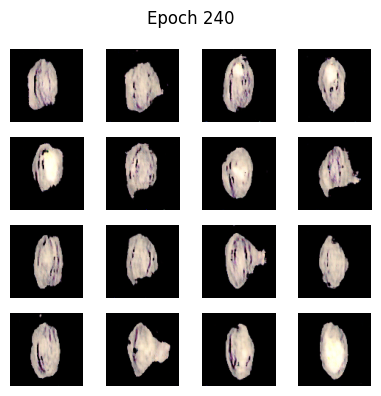

[Modified] Epoch 241/400 | Gen Loss: 0.7467 | Disc Loss: 1.3364
[Modified] Epoch 242/400 | Gen Loss: 0.7416 | Disc Loss: 1.3356
[Modified] Epoch 243/400 | Gen Loss: 0.7501 | Disc Loss: 1.3328
[Modified] Epoch 244/400 | Gen Loss: 0.7468 | Disc Loss: 1.3285
[Modified] Epoch 245/400 | Gen Loss: 0.7492 | Disc Loss: 1.3395
[Modified] Epoch 246/400 | Gen Loss: 0.7550 | Disc Loss: 1.3167
[Modified] Epoch 247/400 | Gen Loss: 0.7506 | Disc Loss: 1.3464
[Modified] Epoch 248/400 | Gen Loss: 0.7513 | Disc Loss: 1.3254
[Modified] Epoch 249/400 | Gen Loss: 0.7488 | Disc Loss: 1.3370
[Modified] Epoch 250/400 | Gen Loss: 0.7465 | Disc Loss: 1.3299
[Modified] Epoch 251/400 | Gen Loss: 0.7507 | Disc Loss: 1.3389
[Modified] Epoch 252/400 | Gen Loss: 0.7524 | Disc Loss: 1.3212
[Modified] Epoch 253/400 | Gen Loss: 0.7477 | Disc Loss: 1.3322
[Modified] Epoch 254/400 | Gen Loss: 0.7511 | Disc Loss: 1.3400
[Modified] Epoch 255/400 | Gen Loss: 0.7506 | Disc Loss: 1.3262
[Modified] Epoch 256/400 | Gen Loss: 0.7

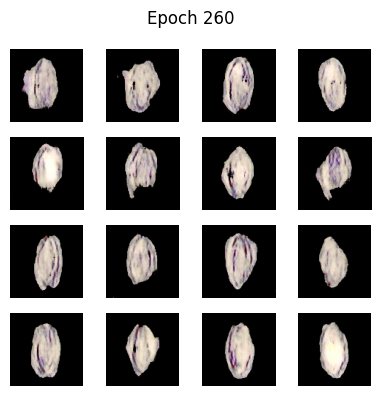

[Modified] Epoch 261/400 | Gen Loss: 0.7555 | Disc Loss: 1.3287
[Modified] Epoch 262/400 | Gen Loss: 0.7649 | Disc Loss: 1.3106
[Modified] Epoch 263/400 | Gen Loss: 0.7620 | Disc Loss: 1.3210
[Modified] Epoch 264/400 | Gen Loss: 0.7622 | Disc Loss: 1.3200
[Modified] Epoch 265/400 | Gen Loss: 0.7707 | Disc Loss: 1.3137
[Modified] Epoch 266/400 | Gen Loss: 0.7614 | Disc Loss: 1.3489
[Modified] Epoch 267/400 | Gen Loss: 0.7667 | Disc Loss: 1.3047
[Modified] Epoch 268/400 | Gen Loss: 0.7709 | Disc Loss: 1.3235
[Modified] Epoch 269/400 | Gen Loss: 0.7511 | Disc Loss: 1.3167
[Modified] Epoch 270/400 | Gen Loss: 0.7638 | Disc Loss: 1.3233
[Modified] Epoch 271/400 | Gen Loss: 0.7515 | Disc Loss: 1.3259
[Modified] Epoch 272/400 | Gen Loss: 0.7671 | Disc Loss: 1.3198
[Modified] Epoch 273/400 | Gen Loss: 0.7561 | Disc Loss: 1.3153
[Modified] Epoch 274/400 | Gen Loss: 0.7664 | Disc Loss: 1.3193
[Modified] Epoch 275/400 | Gen Loss: 0.7580 | Disc Loss: 1.3234
[Modified] Epoch 276/400 | Gen Loss: 0.7

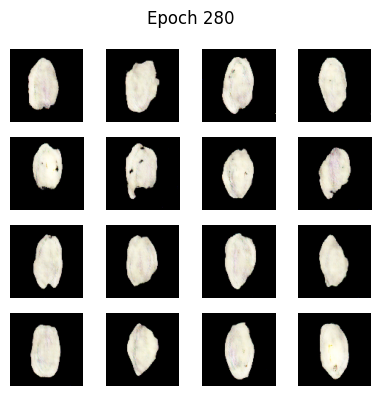

[Modified] Epoch 281/400 | Gen Loss: 0.7580 | Disc Loss: 1.3211
[Modified] Epoch 282/400 | Gen Loss: 0.7688 | Disc Loss: 1.3173
[Modified] Epoch 283/400 | Gen Loss: 0.7666 | Disc Loss: 1.3211
[Modified] Epoch 284/400 | Gen Loss: 0.7599 | Disc Loss: 1.3155
[Modified] Epoch 285/400 | Gen Loss: 0.7711 | Disc Loss: 1.3148
[Modified] Epoch 286/400 | Gen Loss: 0.7625 | Disc Loss: 1.3225
[Modified] Epoch 287/400 | Gen Loss: 0.7625 | Disc Loss: 1.3134
[Modified] Epoch 288/400 | Gen Loss: 0.7674 | Disc Loss: 1.3155
[Modified] Epoch 289/400 | Gen Loss: 0.7718 | Disc Loss: 1.3105
[Modified] Epoch 290/400 | Gen Loss: 0.7812 | Disc Loss: 1.3044
[Modified] Epoch 291/400 | Gen Loss: 0.7558 | Disc Loss: 1.3309
[Modified] Epoch 292/400 | Gen Loss: 0.7676 | Disc Loss: 1.3270
[Modified] Epoch 293/400 | Gen Loss: 0.7692 | Disc Loss: 1.3110
[Modified] Epoch 294/400 | Gen Loss: 0.7740 | Disc Loss: 1.2982
[Modified] Epoch 295/400 | Gen Loss: 0.7883 | Disc Loss: 1.2995
[Modified] Epoch 296/400 | Gen Loss: 0.7

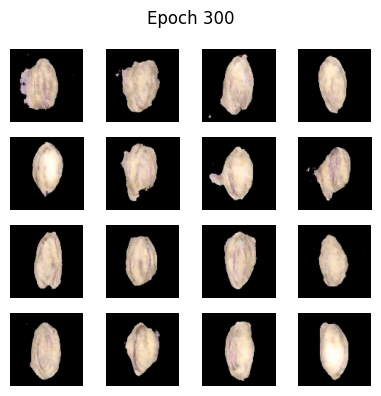

[Modified] Epoch 301/400 | Gen Loss: 0.7697 | Disc Loss: 1.3071
[Modified] Epoch 302/400 | Gen Loss: 0.7613 | Disc Loss: 1.3289
[Modified] Epoch 303/400 | Gen Loss: 0.7878 | Disc Loss: 1.2854
[Modified] Epoch 304/400 | Gen Loss: 0.7706 | Disc Loss: 1.3239
[Modified] Epoch 305/400 | Gen Loss: 0.7671 | Disc Loss: 1.3087
[Modified] Epoch 306/400 | Gen Loss: 0.7865 | Disc Loss: 1.2956
[Modified] Epoch 307/400 | Gen Loss: 0.7599 | Disc Loss: 1.3331
[Modified] Epoch 308/400 | Gen Loss: 0.7913 | Disc Loss: 1.2803
[Modified] Epoch 309/400 | Gen Loss: 0.7748 | Disc Loss: 1.3155
[Modified] Epoch 310/400 | Gen Loss: 0.7710 | Disc Loss: 1.3175
[Modified] Epoch 311/400 | Gen Loss: 0.7855 | Disc Loss: 1.2853
[Modified] Epoch 312/400 | Gen Loss: 0.7798 | Disc Loss: 1.3192
[Modified] Epoch 313/400 | Gen Loss: 0.7678 | Disc Loss: 1.3065
[Modified] Epoch 314/400 | Gen Loss: 0.7953 | Disc Loss: 1.2922
[Modified] Epoch 315/400 | Gen Loss: 0.7886 | Disc Loss: 1.2977
[Modified] Epoch 316/400 | Gen Loss: 0.7

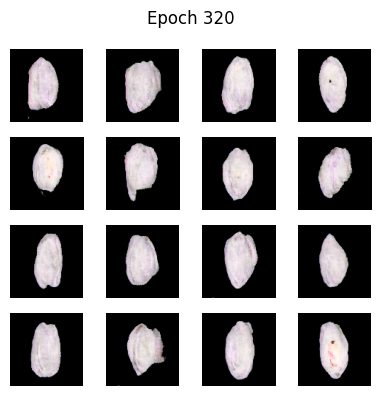

[Modified] Epoch 321/400 | Gen Loss: 0.7821 | Disc Loss: 1.3114
[Modified] Epoch 322/400 | Gen Loss: 0.7781 | Disc Loss: 1.3227
[Modified] Epoch 323/400 | Gen Loss: 0.7599 | Disc Loss: 1.3458
[Modified] Epoch 324/400 | Gen Loss: 0.8006 | Disc Loss: 1.2644
[Modified] Epoch 325/400 | Gen Loss: 0.7890 | Disc Loss: 1.2931
[Modified] Epoch 326/400 | Gen Loss: 0.7905 | Disc Loss: 1.2921
[Modified] Epoch 327/400 | Gen Loss: 0.7815 | Disc Loss: 1.2998
[Modified] Epoch 328/400 | Gen Loss: 0.7785 | Disc Loss: 1.3119
[Modified] Epoch 329/400 | Gen Loss: 0.7885 | Disc Loss: 1.2959
[Modified] Epoch 330/400 | Gen Loss: 0.7811 | Disc Loss: 1.3183
[Modified] Epoch 331/400 | Gen Loss: 0.7838 | Disc Loss: 1.2966
[Modified] Epoch 332/400 | Gen Loss: 0.7929 | Disc Loss: 1.2972
[Modified] Epoch 333/400 | Gen Loss: 0.7726 | Disc Loss: 1.2977
[Modified] Epoch 334/400 | Gen Loss: 0.7763 | Disc Loss: 1.3207
[Modified] Epoch 335/400 | Gen Loss: 0.7802 | Disc Loss: 1.3047
[Modified] Epoch 336/400 | Gen Loss: 0.7

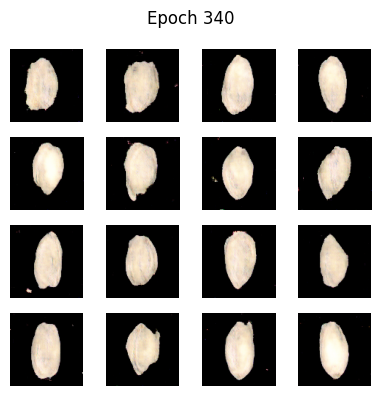

[Modified] Epoch 341/400 | Gen Loss: 0.7647 | Disc Loss: 1.3034
[Modified] Epoch 342/400 | Gen Loss: 0.7886 | Disc Loss: 1.2980
[Modified] Epoch 343/400 | Gen Loss: 0.7604 | Disc Loss: 1.3267
[Modified] Epoch 344/400 | Gen Loss: 0.7842 | Disc Loss: 1.2839
[Modified] Epoch 345/400 | Gen Loss: 0.8065 | Disc Loss: 1.2926
[Modified] Epoch 346/400 | Gen Loss: 0.7705 | Disc Loss: 1.3002
[Modified] Epoch 347/400 | Gen Loss: 0.7966 | Disc Loss: 1.2843
[Modified] Epoch 348/400 | Gen Loss: 0.7664 | Disc Loss: 1.3231
[Modified] Epoch 349/400 | Gen Loss: 0.7935 | Disc Loss: 1.2802
[Modified] Epoch 350/400 | Gen Loss: 0.7981 | Disc Loss: 1.2910
[Modified] Epoch 351/400 | Gen Loss: 0.7659 | Disc Loss: 1.3082
[Modified] Epoch 352/400 | Gen Loss: 0.8003 | Disc Loss: 1.2847
[Modified] Epoch 353/400 | Gen Loss: 0.7813 | Disc Loss: 1.3061
[Modified] Epoch 354/400 | Gen Loss: 0.7872 | Disc Loss: 1.2897
[Modified] Epoch 355/400 | Gen Loss: 0.7797 | Disc Loss: 1.2928
[Modified] Epoch 356/400 | Gen Loss: 0.7

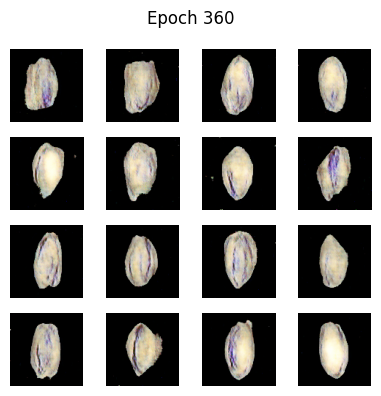

[Modified] Epoch 361/400 | Gen Loss: 0.7867 | Disc Loss: 1.2994
[Modified] Epoch 362/400 | Gen Loss: 0.7829 | Disc Loss: 1.3002
[Modified] Epoch 363/400 | Gen Loss: 0.7879 | Disc Loss: 1.2791
[Modified] Epoch 364/400 | Gen Loss: 0.7888 | Disc Loss: 1.3144
[Modified] Epoch 365/400 | Gen Loss: 0.7668 | Disc Loss: 1.3183
[Modified] Epoch 366/400 | Gen Loss: 0.8157 | Disc Loss: 1.2680
[Modified] Epoch 367/400 | Gen Loss: 0.8107 | Disc Loss: 1.2879
[Modified] Epoch 368/400 | Gen Loss: 0.7903 | Disc Loss: 1.2867
[Modified] Epoch 369/400 | Gen Loss: 0.7921 | Disc Loss: 1.3037
[Modified] Epoch 370/400 | Gen Loss: 0.7788 | Disc Loss: 1.2964
[Modified] Epoch 371/400 | Gen Loss: 0.7962 | Disc Loss: 1.2820
[Modified] Epoch 372/400 | Gen Loss: 0.7713 | Disc Loss: 1.3137
[Modified] Epoch 373/400 | Gen Loss: 0.7960 | Disc Loss: 1.2826
[Modified] Epoch 374/400 | Gen Loss: 0.7889 | Disc Loss: 1.3070
[Modified] Epoch 375/400 | Gen Loss: 0.7803 | Disc Loss: 1.3167
[Modified] Epoch 376/400 | Gen Loss: 0.7

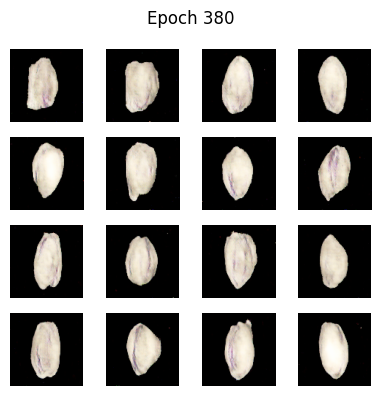

[Modified] Epoch 381/400 | Gen Loss: 0.7667 | Disc Loss: 1.3064
[Modified] Epoch 382/400 | Gen Loss: 0.7951 | Disc Loss: 1.2920
[Modified] Epoch 383/400 | Gen Loss: 0.7732 | Disc Loss: 1.3186
[Modified] Epoch 384/400 | Gen Loss: 0.7998 | Disc Loss: 1.2847
[Modified] Epoch 385/400 | Gen Loss: 0.7909 | Disc Loss: 1.2982
[Modified] Epoch 386/400 | Gen Loss: 0.7821 | Disc Loss: 1.2889
[Modified] Epoch 387/400 | Gen Loss: 0.7893 | Disc Loss: 1.3050
[Modified] Epoch 388/400 | Gen Loss: 0.7830 | Disc Loss: 1.2881
[Modified] Epoch 389/400 | Gen Loss: 0.7882 | Disc Loss: 1.2929
[Modified] Epoch 390/400 | Gen Loss: 0.7823 | Disc Loss: 1.2878
[Modified] Epoch 391/400 | Gen Loss: 0.7903 | Disc Loss: 1.2979
[Modified] Epoch 392/400 | Gen Loss: 0.7745 | Disc Loss: 1.3014
[Modified] Epoch 393/400 | Gen Loss: 0.7965 | Disc Loss: 1.2874
[Modified] Epoch 394/400 | Gen Loss: 0.7749 | Disc Loss: 1.3094
[Modified] Epoch 395/400 | Gen Loss: 0.7862 | Disc Loss: 1.3026
[Modified] Epoch 396/400 | Gen Loss: 0.7

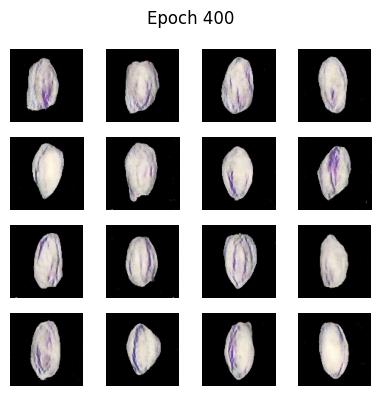

In [ ]:
train2(train_dataset, generator2, discriminator2, epochs=400)

Training Modified GAN...
[Modified] Epoch 1/20 | Gen Loss: 0.7844 | Disc Loss: 1.2960


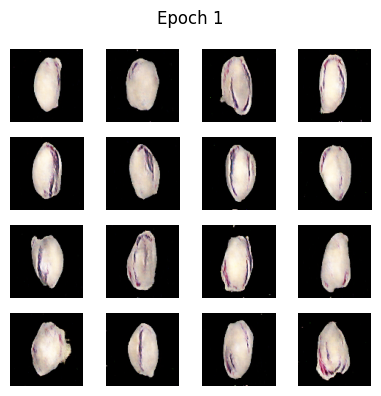

[Modified] Epoch 2/20 | Gen Loss: 0.8065 | Disc Loss: 1.2826
[Modified] Epoch 3/20 | Gen Loss: 0.7834 | Disc Loss: 1.2981
[Modified] Epoch 4/20 | Gen Loss: 0.7914 | Disc Loss: 1.2821
[Modified] Epoch 5/20 | Gen Loss: 0.8011 | Disc Loss: 1.2755
[Modified] Epoch 6/20 | Gen Loss: 0.8037 | Disc Loss: 1.2767
[Modified] Epoch 7/20 | Gen Loss: 0.7872 | Disc Loss: 1.2916
[Modified] Epoch 8/20 | Gen Loss: 0.8025 | Disc Loss: 1.2683
[Modified] Epoch 9/20 | Gen Loss: 0.8037 | Disc Loss: 1.2812
[Modified] Epoch 10/20 | Gen Loss: 0.7931 | Disc Loss: 1.2798
[Modified] Epoch 11/20 | Gen Loss: 0.8092 | Disc Loss: 1.2670
[Modified] Epoch 12/20 | Gen Loss: 0.7978 | Disc Loss: 1.2829
[Modified] Epoch 13/20 | Gen Loss: 0.8011 | Disc Loss: 1.2765
[Modified] Epoch 14/20 | Gen Loss: 0.8065 | Disc Loss: 1.2757
[Modified] Epoch 15/20 | Gen Loss: 0.7896 | Disc Loss: 1.2902
[Modified] Epoch 16/20 | Gen Loss: 0.7962 | Disc Loss: 1.2915
[Modified] Epoch 17/20 | Gen Loss: 0.8013 | Disc Loss: 1.2661
[Modified] Epoch

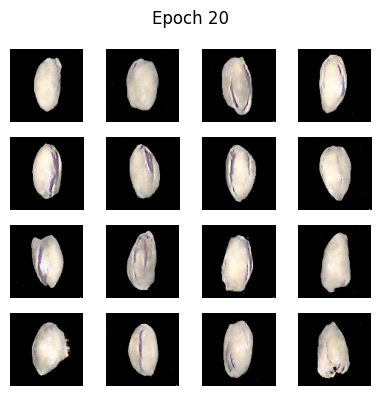

In [ ]:
train2(train_dataset, generator2, discriminator2, epochs=20)

## C. Evaluasi FID

In [ ]:

feature_extractor = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

def resize_images(imgs, target_size=(299, 299)):
    resized_imgs = []
    for img in imgs:
        resized = tf.image.resize(img, target_size).numpy()
        resized = np.clip(resized, 0, 255).astype(np.uint8)
        resized_imgs.append(resized)
    return np.array(resized_imgs)

def get_activations(images, model):
    images = preprocess_input(images.astype(np.float32))
    return model.predict(images, verbose=0)

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1 @ sigma2, disp=False)
    if not np.isfinite(covmean).all():
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = sqrtm((sigma1 + offset) @ (sigma2 + offset))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)


Di sini, saya menggunakan Fréchet Inception Distance (FID) yaitu sebuah metrik yang umum dipakai untuk mengevaluasi kualitas gambar yang dihasilkan oleh model generatif seperti GAN. FID membandingkan distribusi fitur antara gambar asli dan gambar sintetis yang diekstraksi oleh model InceptionV3. Semakin rendah nilai FID, artinya distribusi gambar sintetis semakin mirip dengan gambar asli.

In [ ]:
num_images = 100
noise_dim = 100
noise = tf.random.normal([num_images, noise_dim])

#Baseline generator
generated_images_base = generator(noise, training=False).numpy()
fake_images_base = ((generated_images_base + 1.0) * 127.5).astype(np.uint8)
#Modif generator
generated_images_mod = generator2(noise, training=False).numpy()
fake_images_mod = ((generated_images_mod + 1.0) * 127.5).astype(np.uint8)
#Real images
real_images = ((images[:num_images] + 1.0) * 127.5).astype(np.uint8)

real_resized = resize_images(real_images)
fake_resized_baseline = resize_images(fake_images_base)
fake_resized_mod = resize_images(fake_images_mod)

Untuk mengevaluasi kualitas gambar sintetis yang dihasilkan oleh GAN, saya menggunakan metrik FID yang membandingkan distribusi fitur antara gambar asli dan gambar hasil generator. Setelah mengambil 100 sampel dari data asli dan menghasilkan 100 gambar sintetis dari masing-masing generator (baseline dan modifikasi), gambar-gambar tersebut di-resize ke 299x299 dan diproses melalui InceptionV3 untuk mendapatkan representasi fitur. Dari hasil ekstraksi ini, saya menghitung mean dan covariance-nya sebagai dasar perhitungan FID.

In [ ]:
act_real = get_activations(real_resized, feature_extractor)
act_base = get_activations(fake_resized_baseline, feature_extractor)
act_mod  = get_activations(fake_resized_mod, feature_extractor)

mu_real, sigma_real = act_real.mean(axis=0), np.cov(act_real, rowvar=False)
mu_base, sigma_base = act_base.mean(axis=0), np.cov(act_base, rowvar=False)
mu_mod, sigma_mod   = act_mod.mean(axis=0), np.cov(act_mod, rowvar=False)

fid_base = calculate_frechet_distance(mu_real, sigma_real, mu_base, sigma_base)
fid_mod  = calculate_frechet_distance(mu_real, sigma_real, mu_mod, sigma_mod)

print(f"FID Baseline Generator: {fid_base:.4f}")
print(f"FID Modified Generator: {fid_mod:.4f}")

FID Baseline Generator: 239.8319
FID Modified Generator: 180.8364


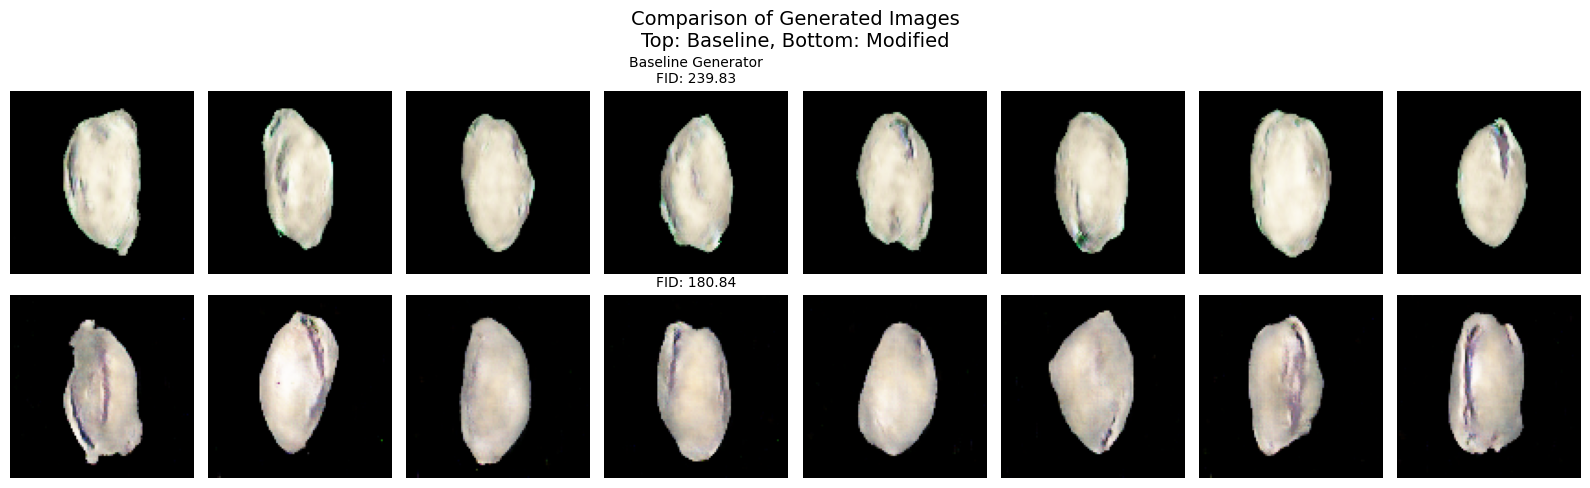

In [ ]:


plt.figure(figsize=(16, 5))

for i in range(8):
    plt.subplot(2, 8, i + 1)
    plt.imshow(fake_images_base[i])
    plt.axis('off')
    if i == 3:
        plt.title(f'Baseline Generator\nFID: {fid_base:.2f}', fontsize=10)
for i in range(8):
    plt.subplot(2, 8, 8 + i + 1)
    plt.imshow(fake_images_mod[i])
    plt.axis('off')
    if i == 3:
        plt.title(f'Modified Generator\nFID: {fid_mod:.2f}', fontsize=10)

plt.suptitle("Comparison of Generated Images\nTop: Baseline, Bottom: Modified", fontsize=14)
plt.tight_layout()
plt.show()


Hasil evaluasi menunjukkan bahwa model generator baseline menghasilkan FID sebesar 239.83, sementara generator hasil modifikasi menghasilkan nilai yang lebih rendah yaitu 180.84. Perbedaan ini cukup mencolok dan mengindikasikan bahwa arsitektur yang telah dimodifikasi (dengan penambahan batch normalization, penggunaan LeakyReLU pada discriminator, serta desain kernel yang lebih dalam pada generator) mampu menghasilkan gambar yang distribusi fiturnya lebih mendekati data asli. Nilai FID yang lebih rendah menunjukkan bahwa modifikasi yang dilakukan memberikan perbaikan yang bermakna dalam kualitas generatif.

Secara keseluruhan, modifikasi arsitektur terbukti efektif dalam meningkatkan performa model GAN, terutama dalam hal kestabilan pelatihan dan kemiripan visual. Penggunaan teknik normalisasi dan aktivasi yang lebih stabil berkontribusi terhadap hasil akhir yang lebih halus dan konsisten. Meskipun visual gambar sintetis masih belum sepenuhnya tajam jika dilihat secara subjektif, penurunan FID ini merupakan indikator positif bahwa model berada di jalur yang benar untuk dikembangkan lebih lanjut.

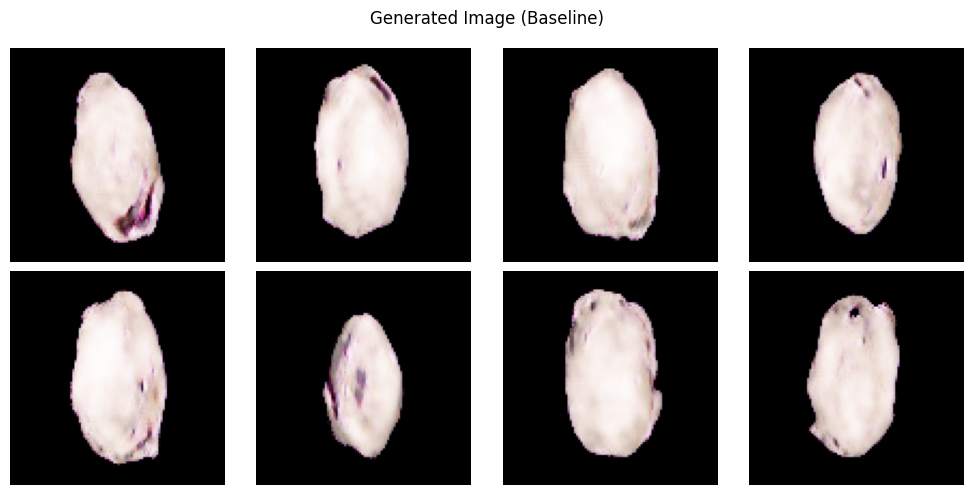

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(fake_images[i])
    plt.axis('off')
plt.suptitle("Generated Image (Baseline)")
plt.tight_layout()
plt.show()

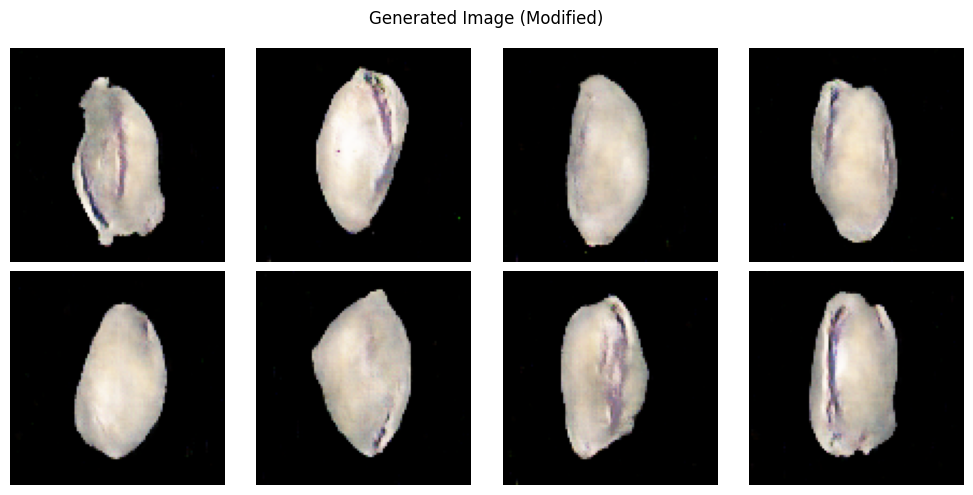

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(fake_images_mod[i])
    plt.axis('off')
plt.suptitle("Generated Image (Modified)")
plt.tight_layout()
plt.show()